In [1]:
# install dependencies
# !pip install casadi

# Obstacle avoidance with TurtleBot (Simon avoiding Elena and Sinda)



In [2]:
import numpy as np
from math import *

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from copy import deepcopy, copy

## Optimization-based Motion Planning: Static Obstacles
$$
\begin{aligned}
	\min_{\mathbf{u}_{1:N-1}, \mathbf{x}_{1:N}} \quad &\sum_{t=1}^{N} J(\mathbf{x}_t, \mathbf{u}_t)\\
	\textrm{s.t.  } \quad  &\mathbf{x}_{t+1} = \mathbf{f}\left(\mathbf{x}_t, \mathbf{u}_t\right) \hspace{0.5cm} &&\forall t = 1, \cdots, N-1\\
  &\mathbf{x}_{t}  \notin \mathcal{X}_{obs} \hspace{0.5cm} &&\forall t = 1, \cdots, N\\
  & \mathbf{u}_t \in \mathcal{U} &&\forall t = 1, \cdots, N-1\\
	& \mathbf{x}_N \in \mathcal{X}_g, \mathbf{x}_0 = \mathbf{x}(t_0)
    \end{aligned}.
$$
where $J$ is the stage cost and $\mathcal{X}_{obs}$ is the set of obstacle positions.

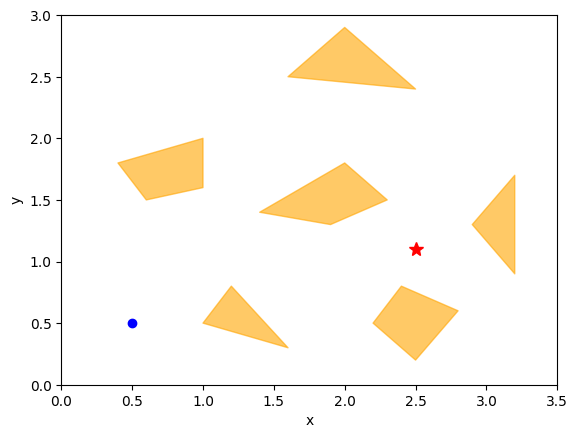

In [3]:
# Initial state of the robot
x0 = [0.5, 0.5, 0.]

# Goal state
x_ref = [3., 2.3, 0.]
x_ref = [2.5, 1.1, 0.]

# For collision checking we will overapproximate the robot with a circle of radius r
r_robot = 0.15

# Define obstacles in the environment (Each obstacle is defined by a list of its vertex positions)
obstacles = []
obstacles.append([[1., 0.5], [1.2, 0.8], [1.6, 0.3]])
obstacles.append([[0.6, 1.5], [0.4, 1.8], [1., 2.], [1., 1.6]])
obstacles.append([[1.4, 1.4], [2., 1.8], [2.3, 1.5], [1.9, 1.3]])
obstacles.append([[2.9, 1.3], [3.2, 1.7], [3.2, 0.9]])
obstacles.append([[2.5, 0.2], [2.2, 0.5], [2.4, 0.8], [2.8, 0.6]])
obstacles.append([[1.6, 2.5], [2., 2.9], [2.5, 2.4]])

# Plot environment
fig,ax = plt.subplots()

patches = []
for obs in obstacles:
    p = Polygon(obs)
    patches.append(p)


p_col = PatchCollection(patches, alpha=0.6, color = 'orange')
ax.add_collection(deepcopy(p_col))
ax.plot([x0[0]], [x0[1]], marker='o', color="b")
ax.plot([x_ref[0]], [x_ref[1]], marker='*', color="r", markersize=10)
ax.set_xlim([0,3.5])
ax.set_ylim([0,3])
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()


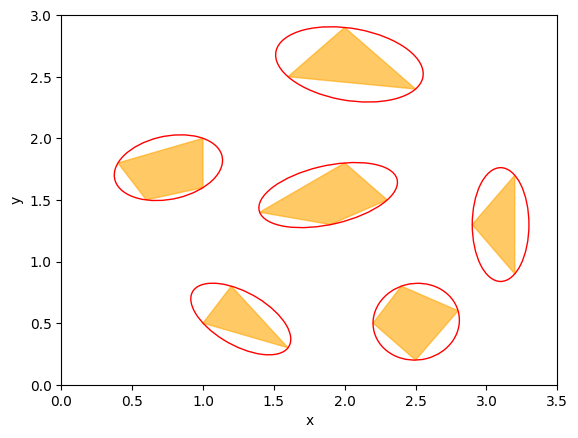

In [4]:
from matplotlib.patches import Ellipse

# Minimum volume enclosing ellipsoid algorithm
def mvee(points, tol=0.0001):
    """
    Finds the ellipse equation in "center form"
    (x-c).T * A * (x-c) = 1
    c is the center of the ellipsoid.
    A is a positive definite matrix that defines the shape and orientation of the ellipsoid.
    """
    N, d = points.shape
    Q = np.column_stack((points, np.ones(N))).T
    err = tol+1.0
    u = np.ones(N)/N
    while err > tol:
        X = np.dot(np.dot(Q, np.diag(u)), Q.T)
        M = np.diag(np.dot(np.dot(Q.T, np.linalg.inv(X)), Q))
        jdx = np.argmax(M)
        step_size = (M[jdx]-d-1.0)/((d+1)*(M[jdx]-1.0))
        new_u = (1-step_size)*u
        new_u[jdx] += step_size
        err = np.linalg.norm(new_u-u)
        u = new_u
    c = np.dot(u, points)
    A = np.linalg.inv(np.dot(np.dot(points.T, np.diag(u)), points)
               - np.multiply.outer(c, c))/d
    return A, c

# initialize list of ellipsoids [(A_1, c_1), ...]
obstacle_ellipsoids = []

for obs in obstacles:
    A, c = mvee(np.array(obs))
    obstacle_ellipsoids.append((A, c))


# Visualize environment
fig, ax = plt.subplots()

ax.add_collection(deepcopy(p_col))

ellipses = []
for (A, c) in obstacle_ellipsoids:
    # Eigendecomposition of A
    Lambda, R = np.linalg.eig(A)
    width = 2 * sqrt(1 / Lambda[0])
    height = 2 * sqrt(1 / Lambda[1])
    angle = atan2(R[1, 0], R[0, 0]) * 180 / pi
    ellipse = Ellipse(c, width, height, angle=angle, facecolor='none')
    ellipse.set_edgecolor([1, 0, 0])
    ellipses.append(ellipse)
    ax.add_artist(copy(ellipse))


ax.set_xlim([0,3.5])
ax.set_ylim([0,3])
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()


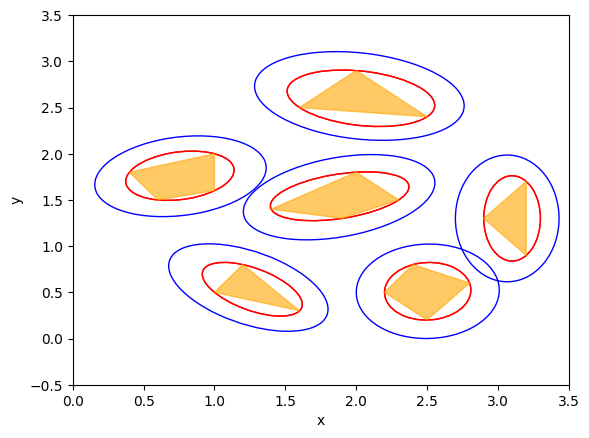

In [5]:
# radius obstacle
r = r_robot

def enlarge_obstacle_fixed_distance(obstacle, distance):    
    obstacle = np.array(obstacle) # Convert vertices to a numpy array
    center = np.mean(obstacle, axis=0) # Compute the centroid
    vectors = obstacle - center # Compute vectors from the centroid to the vertices

    norms = np.linalg.norm(vectors, axis=1, keepdims=True) # Normalize the vectors
    unit_vectors = vectors / norms  # Unit directions

    enlarged_obstacle = obstacle + unit_vectors * distance # Add the fixed distance
    
    return enlarged_obstacle.tolist()


# Enlarge each obstacle by a fixed distance
distance = 0.2 # For example, add 0.1 units
enlarged_obstacles = [enlarge_obstacle_fixed_distance(obstacle, distance) for obstacle in obstacles]

obstacle_enlarged_ellipsoids = []
for obs in enlarged_obstacles:
    A, c = mvee(np.array(obs))
    
    obstacle_enlarged_ellipsoids.append((A, c))

enlarged_ellipses = []
for (A, c) in obstacle_ellipsoids:
    # Eigendecomposition of A
    Lambda, R = np.linalg.eig(A)
    width = 2 * sqrt(1 / Lambda[0])
    height = 2 * sqrt(1 / Lambda[1])
    angle = atan2(R[1, 0], R[0, 0]) * 180 / pi
    ellipse = Ellipse(c, width, height, angle=angle, facecolor='none')
    ellipse.set_edgecolor([1, 0, 0])
    ellipses.append(ellipse)
    ax.add_artist(copy(ellipse))

# init empty lists
enlarged_ellipses = []

for (A, c) in obstacle_enlarged_ellipsoids:
    enlarged_ellipses.append((A, c))

# generate plot objects
enlarged_ellipses_patches = []
for (A, c) in enlarged_ellipses:
  Lambda, R = np.linalg.eig(A)
  width = 2 * sqrt(1 / Lambda[0])
  height = 2 * sqrt(1 / Lambda[1])
  angle = atan2(R[1, 0], R[0, 0]) * 180 / pi
  ellipse = Ellipse(c, width, height, angle=angle, facecolor='none')
  ellipse.set_edgecolor([0, 0, 1])
  enlarged_ellipses_patches.append(ellipse)

fig, ax = plt.subplots()

for e_ in enlarged_ellipses_patches:
    ax.add_artist(copy(e_))

for e in ellipses:
    ax.add_artist(copy(e))

ax.add_collection(deepcopy(p_col))
ax.set_xlim([0,3.5])
ax.set_ylim([-0.5,3.5])
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

In [6]:
import casadi
import numpy as np

opti = casadi.Opti()

# Trajectory length
NPRED = 100

# state trajectory
X = opti.variable(3, NPRED)
# controls
U = opti.variable(2,NPRED)

# Weight matrices
Q = 10 * np.eye(3)
R = np.diag([2, 2])
P = 10 * Q

XMIN = -1 * 0.2 *  np.array([1.0 ,1.0, 1.0]) #np.ones(3)          # State limits
XMAX =  1 * 0.2 * np.array([1.0 ,1.0, 1.0]) #np.ones(3) 
UMIN = 0
UMAX = 1
TE = 0.1

#  Nonlinear dynamics of the unicycle model with omega_r and omega_l
f_dynamics = casadi.vertcat(U[0] * casadi.cos(X[2]), U[0] * casadi.sin(X[2]), U[1])
f_dynamics_func = casadi.Function('f_dynamics', [X, U], [f_dynamics]) # Wrap it as a CasADi function

J = 0 
for k in range(0, NPRED - 1):
  J += casadi.mtimes([(X[:, k] - x_ref).T, Q, (X[:, k] - x_ref)]) + casadi.mtimes([U[:, k].T, R, U[:, k]])
J += casadi.mtimes([(X[:, NPRED - 1] - x_ref).T, P, (X[:, NPRED - 1] - x_ref)])

opti.minimize(J)  # Minimize the total cost

# Dynamics constraints
for k in range(NPRED-1):
  opti.subject_to(X[:, k+1] == (X[:, k] + TE * f_dynamics_func(X[:, k], U[:, k])))
  opti.subject_to(XMIN <= (X[:, k + 1] - X[:, k]))
  opti.subject_to((X[:, k + 1] - X[:, k]) <= XMAX)

# Position constraints
# the position of the obstacles is already known
for obstacle in enlarged_ellipses:
  print(obstacle)
  A_tilde, c_tilde = obstacle
  for k in range(NPRED-1):
    opti.subject_to(casadi.mtimes([(X[0:2, k+1] - c_tilde).T, A_tilde, (X[0:2, k+1] - c_tilde)]) > 1)

# Actuator saturation constraints
for k in range(NPRED-1):
  opti.subject_to(U[0, k] >= UMIN)
  opti.subject_to(U[0, k] <= UMAX)

# Initial and final state constraints
opti.subject_to(X[:, 0] == x0)
opti.subject_to(X[:, -1] == x_ref)

opti.solver('ipopt')
sol = opti.solve()

traj = sol.value(X)
controls = sol.value(U)

(array([[4.186816 , 2.463302 ],
       [2.463302 , 5.9168717]]), array([1.23896123, 0.55150969]))
(array([[ 2.85599205, -0.82056784],
       [-0.82056784,  5.47476808]]), array([0.76001895, 1.75615385]))
(array([[ 2.47007975, -1.21969245],
       [-1.21969245,  5.29893983]]), array([1.87941733, 1.52935136]))
(array([[7.47855981, 0.        ],
       [0.        , 2.12542948]]), array([3.06567142, 1.3       ]))
(array([[ 3.92983591, -0.0879341 ],
       [-0.0879341 ,  3.83074843]]), array([2.50495285, 0.51119777]))
(array([[1.92101983, 0.65076047],
       [0.65076047, 4.56023213]]), array([2.02228815, 2.625007  ]))

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
*************************************************************************

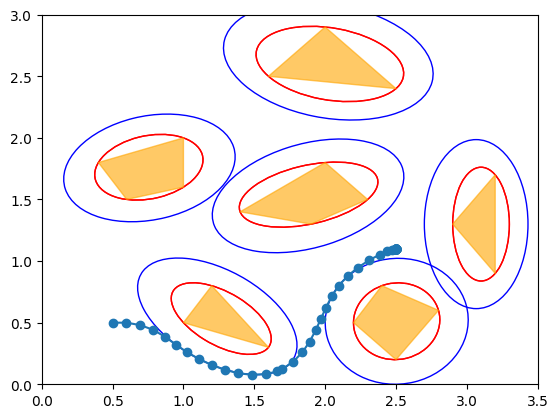

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(traj[0, :], traj[1, :], marker='o')

for e_ in enlarged_ellipses_patches:
    ax1.add_artist(copy(e_))

for e in ellipses:
    ax1.add_artist(copy(e))

ax1.add_collection(copy(p_col))
ax1.set_xlim([0,3.5])
ax1.set_ylim([0,3])
plt.show()

ax1.set_xlabel("x")
ax1.set_ylabel("y")


plt.show()


**Aaand also animate!**

In [8]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook
%matplotlib inline
%matplotlib notebook
%matplotlib notebook
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle
from IPython.display import HTML
from math import *

def animation_func(i, data):
    x = data[0]
    y = data[1]
    theta = data[2]
    # Drone dimension: width l
    l = 0.3
    p1 = [x[i] + cos(theta[i]) * l/2, y[i] + sin(theta[i]) * l/2]
    p2 = [x[i] - cos(theta[i]) * l/2, y[i] - sin(theta[i]) * l/2]
    line1.set_xdata([p1[0], p2[0]])
    line1.set_ydata([p1[1], p2[1]])

    # Update circle position
    robot_circle.center = (x[i], y[i])  # Update the center of the circle

    # Plot trajectory
    pt, = ax.plot([x[i]], [y[i]], "g.", markersize=1)

    ax.add_collection(deepcopy(p_col))

    return line1, pt


fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_xlim([0., 4.])
ax.set_ylim([0, 4.])
line1, = ax.plot([x0[0]-0.15, x0[0] + 0.15], [0., 0.], 'ko-', lw=1.5, markersize=5)

# Initialize the circle representing the drone
robot_circle = Circle((0, 0), 0.15, color='blue', alpha=0.6)  # Circle with radius 0.15
ax.add_patch(robot_circle)

for e_ in enlarged_ellipses_patches:
    ax.add_artist(copy(e_))

for e in ellipses:
    ax.add_artist(copy(e))

x_data = traj[0, :]
y_data = traj[1, :]
theta_data = traj[2, :]
animation = FuncAnimation(fig, animation_func, fargs=((x_data, y_data, theta_data),),
                          frames=NPRED, interval=50, blit=True)
# plt.show()
HTML(animation.to_html5_video())

<IPython.core.display.Javascript object>

## Optimization-based Motion Planning: Dynamic Obstacles
Now we will start with moving obstacles! In this case we will assume that the obstacles start in the previous configuration and have a constant velocity in one direction. In the following, create a list of the obstacles at each timestep $t = 0, \dots, N$.

In [9]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook

import math

# velocity vectors in xy-plane
velocity_dirs = [[1., 0.], [1., 0.4], [0.4, -1.], [-1, 0.5], [-0.1, 1.], [1., 0.2]]

# velocity magnitudes
velocities = [0.1, 0.15, 0.1, 0.4, 0.3, 0.05]

# list of obstacles at each timestep
timed_obstacles = []
timed_obstacles.append(deepcopy(obstacles))

for k in range(1, NPRED):

  list_new_obstacles = []
  for i in range(len(obstacles)):

    # Get the velocity direction and magnitude for this obstacle
    vel_dir = velocity_dirs[i]
    angle = math.atan2(vel_dir[1], vel_dir[0])
    vel_mag = velocities[i]
    obstacle = timed_obstacles[k-1][i]

    # Update each obstacle
    new_obstacles = []
    for j in range(len(obstacle)):
      updated_x = obstacle[j][0] +  TE * cos(angle) * vel_mag
      updated_y = obstacle[j][1] +  TE * sin(angle) * vel_mag
      updated_obstacle =[updated_x, updated_y]
      new_obstacles.append(updated_obstacle)

    list_new_obstacles.append(new_obstacles)
  timed_obstacles.append(list_new_obstacles)

def animation_obstacles(i):
    for j, p in enumerate(moving_patches):
        new_pos = np.append(timed_obstacles[i][j], [timed_obstacles[i][j][0]], axis=0)
        p.set_xy(new_pos)

    return moving_patches,


fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_xlim([0., 4.])
ax.set_ylim([0., 4.])

moving_patches = []
for p in patches:
  moving_patches.append(Polygon(p.get_xy()))

for p in moving_patches:
    p.set_color([1, 0, 0])
    ax.add_patch(p)

animation = FuncAnimation(fig, animation_obstacles, frames=NPRED, interval=50, blit=True)

HTML(animation.to_html5_video())

<IPython.core.display.Javascript object>

To use the same constraint formulations as before, we need the ellipsoidal overapproximations over time!

In [10]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook

# list of list of ellipses at each time step
timed_ellipses = []

# list of obstacles at each timestep
timed_enlarged_obstacles = []
timed_enlarged_obstacles.append(deepcopy(enlarged_obstacles))

# for the enlarged obstacles
for k in range(1, NPRED):

  list_new_enlarged_obstacles = []
  for i in range(len(enlarged_obstacles)):

    # Get the velocity direction and magnitude for this obstacle
    vel_dir = velocity_dirs[i]
    angle = math.atan2(vel_dir[1], vel_dir[0])
    vel_mag = velocities[i]
    obstacle = timed_obstacles[k-1][i]

    # Update each obstacle
    new_obstacles = []
    for j in range(len(obstacle)):
      updated_x = obstacle[j][0] +  TE * cos(angle) * vel_mag
      updated_y = obstacle[j][1] +  TE * sin(angle) * vel_mag
      updated_obstacle =[updated_x, updated_y]
      new_obstacles.append(updated_obstacle)

    list_new_enlarged_obstacles.append(new_obstacles)
  timed_enlarged_obstacles.append(list_new_enlarged_obstacles)

for elements in timed_enlarged_obstacles:
  list_ellipses = []
  for obs in elements:
    A, c = mvee(np.array(obs))
    list_ellipses.append((A, c))
  timed_ellipses.append(list_ellipses)

# Animations
def animation_ellipses(i):
    for j, p in enumerate(moving_patches):
        new_pos = np.append(timed_obstacles[i][j], [timed_obstacles[i][j][0]], axis=0)
        p.set_xy(new_pos)

    for j, e in enumerate(moving_ellipses):
        e.set_center(timed_ellipses[i][j][1])

    return moving_patches, moving_ellipses,


fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_xlim([0., 4.])
ax.set_ylim([0., 4.])

# moving_patches = copy(patches)
moving_patches = []
for p in patches:
  moving_patches.append(Polygon(p.get_xy()))
# moving_ellipses = copy(enlarged_ellipses_patches
moving_ellipses = []
for e in enlarged_ellipses_patches:
  moving_ellipses.append(Ellipse(e.get_center(), e.width, e.height, angle=e.angle, facecolor='none'))

for p in moving_patches:
    p.set_color([1, 0, 0])
    ax.add_patch(p)

for e in moving_ellipses:
    e.set_edgecolor([0, 0, 1])
    ax.add_artist(e)

animation = FuncAnimation(fig, animation_ellipses, frames=NPRED, interval=50, blit=True)

# plt.show()
HTML(animation.to_html5_video())

<IPython.core.display.Javascript object>

**We're almost there!** Formulate the optimization problem in the case of moving obstacles!

In [16]:
# Initial & Goal states
x0 = [0.5, 0.5, 0.]
x_ref = [3., 2.3, 0.]

# state trajectory
X = opti.variable(3, NPRED)
# controls
U = opti.variable(2,NPRED)

# Weight matrices
Q = 10 * np.eye(3)  # 3x3 identity matrix
R = np.diag([2, 2])
P = 10 * Q

J = 0  # Initialise le coût total
for k in range(0, NPRED-1):
    J += casadi.mtimes([(X[:, k] - x_ref).T, Q, (X[:, k] - x_ref)]) + casadi.mtimes([U[:, k].T, R, U[:, k]])
J += casadi.mtimes([(X[:, NPRED - 1] - x_ref).T, P, (X[:, NPRED - 1] - x_ref)]) + casadi.mtimes([U[:, k].T, R, U[:, k]])

opti.minimize(J)  # Minimize the total cost

# Dynamics constraints
for k in range(NPRED-1):
  opti.subject_to(X[:, k+1] == (X[:, k] + TE * f_dynamics_func(X[:, k], U[:, k])))
  opti.subject_to(XMIN <= (X[:, k + 1] - X[:, k]))
  opti.subject_to((X[:, k + 1] - X[:, k]) <= XMAX)

# Position constraints
# obstacles are changing position at each moment with a constant velocity
for k in range(NPRED - 1):
  for obstacle in timed_ellipses[k+1]:
    A_tilde, c_tilde = obstacle
    opti.subject_to(casadi.mtimes([(X[0:2, k + 1] - c_tilde).T, A_tilde, (X[0:2, k + 1] - c_tilde)]) > 1)


# Actuator saturation constraints
for k in range(NPRED-1):
  opti.subject_to(U[0, k] >= UMIN)
  opti.subject_to(U[0, k] <= UMAX)

# Initial and final state constraints
opti.subject_to(X[:, 0] == x0)
opti.subject_to(X[:, -1] == x_ref)

opti.solver('ipopt')
sol = opti.solve()

traj = sol.value(X)
controls = sol.value(U)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     4380
Number of nonzeros in inequality constraint Jacobian.:    10296
Number of nonzeros in Lagrangian Hessian.............:     2481

Total number of variables............................:     2000
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1212
Total number of inequality constraints...............:     5544
        inequality constraints with only lower bounds:     3960
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     1584

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5576100e+04 3.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

Visualization of the obtained trajectory.

In [17]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from math import *

def animation_func(i, data):
    x = data[0]
    y = data[1]
    theta = data[2]
    # Drone dimension: width l
    l = 0.3
    p1 = [x[i] + cos(theta[i]) * l/2, y[i] + sin(theta[i]) * l/2]
    p2 = [x[i] - cos(theta[i]) * l/2, y[i] - sin(theta[i]) * l/2]
    line1.set_xdata([p1[0], p2[0]])
    line1.set_ydata([p1[1], p2[1]])
    # Plot trajectory
    pt, = ax.plot([x[i]], [y[i]], "g.", markersize=1)

    # Update circle position
    robot_circle.center = (x[i], y[i])  # Update the center of the circle

    for j, p in enumerate(moving_patches):
        new_pos = np.append(timed_obstacles[i][j], [timed_obstacles[i][j][0]], axis=0)
        p.set_xy(new_pos)

    return line1, pt, moving_patches,

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_xlim([0., 4.])
ax.set_ylim([0., 4.])
line1, = ax.plot([x0[0]-0.15, x0[0] + 0.15], [0., 0.], 'ko-', lw=1.5, markersize=5)

moving_patches = []
for p in patches:
  moving_patches.append(Polygon(p.get_xy()))

for p in moving_patches:
    p.set_color([1, 0, 0])
    ax.add_patch(p)

# Initialize the circle representing the drone
robot_circle = Circle((0, 0), 0.15, color='blue', alpha=0.6)  # Circle with radius 0.15
ax.add_patch(robot_circle)

x_data = traj[0, :]
y_data = traj[1, :]
theta_data = traj[2, :]
animation = FuncAnimation(fig, animation_func, fargs=((x_data, y_data, theta_data),),

                          frames=NPRED, interval=50, blit=True)
# plt.show()
HTML(animation.to_html5_video())

<IPython.core.display.Javascript object>

# What if we have uncertainties such as initial positions? Feedback Motion Primitives!

In the previous setting, we have found an open loop trajectory for our robot. When applying this to a real robot it will most likely fail if we do not use a tracking controller to account for small deviations from the reference trajectory.

However, if we deviate from the reference trajectory, we are not ensured anymore that the robot will move on a collision-free trajectory. So in safety-critical applications, it is important to consider safety on different levels of the planning hierarchy (motion planning, control) in order to make our robots more robust.

In this section, we will look into Feedback motion primitives to ensure safety even if the reference trajectory cannot be tracked accurately.

In [13]:
!pip install pypolycontain
import pypolycontain as pp

# shapely is used for collision checking. It might not necessarily refer to zonotopes
# but we can always transfer
# https://shapely.readthedocs.io/en/stable/manual.html
from shapely.geometry import box, MultiPoint
from shapely.geometry import Polygon as Poly

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from copy import deepcopy, copy
from math import *

import numpy as np

# for the animations
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

Defaulting to user installation because normal site-packages is not writeable


ModuleNotFoundError: No module named 'scipy'

We first use our well-known dynamics model to be able to simulate our system.

In [ ]:
def dynamics(x, u):
    """
    Inputs: current state of the system x, control input u
    Output: derivative of the state vector
    """
    dx = np.array([- u[:, 0] * np.sin(x[:, 2]), u[:, 0] * np.cos(x[:, 2]), u[:, 1]]).T
    return dx


def discrete_dynamics(x, u):
    """
    Inputs: current state of the system x, control input u
    Output: next state vector
    """
    dt = 0.1
    x_next = x + dt * dynamics(x, u)
    return x_next

Next, we will define our set of initial states as well as our input set. From this we will construct a **single** feedback motion primitive. Later, we will generalize these results to obtain multiple primitives that can be used for planning. In the following, define two zonotopes $X0$ and $U$ for the previously mentioned sets. The initial set is centered at the origin with orientation zero and has a total width of $0.1$ in each state direction. The input set is defined as $U = \left\{[u_1, u_2]^T \in \mathbb{R}^2 \mid 0.2 \leq u_1 \leq 0.3, 0.5 \leq u_2 \leq 1\right\}$.

In [ ]:
nx = 3
nu = 2

# X0 = ...
c_X0 = np.array([0, 0, 0])
g_X0 = np.array([0.05, 0, 0], [0, 0.05, 0], [0, 0, 0.05])
X0 = pp.zonotope(x=c_X0, G=g_X0)

# U = ...
c_U =np.array([(0.2+0.3)/2, (0.5+1)/2]) # = [0.25, 0.75]
g_U = na.array([0.05, 0.25])
U = pp.zonotope(x=c_U, g=g_U)

# visualize initial set
fig, ax = plt.subplots()
pp.visualize([pp.zonotope(x=X0.x[0:2], G=X0.G[0:2, :])], ax=ax, fig=fig)


Next, we would like to be able to sample trajectories from our system given the initial states and the input sets. For that purpose, we need a function that allows us to sample a point from a zonotope.

In [ ]:
def sample_zonotope(zt):
  """
  Input: pp zonotope
  Output: uniformly sampled point inside zonotope
  """

We will now sample a bunch of initial states and input trajectories of length $N_s = 20$ to fit a linear model to the multi-step solution of our dynamical system. Fill the matrices!

In [ ]:
# number of timesteps for feedback motion primitive
N_s = 20

# sampled trajectories
n_samples = 10000

state_traces = np.zeros((n_samples, nx, N_s))
input_traces = np.zeros((n_samples, nu, N_s - 1))

#PUT YOUR CODE HERE

Next, we're gonna fit a linear model for the transition from initial state $x_0$ to the state after $x_{T}$ after $N_s=20$ timesteps. Note, that this is not a linear model relating the state at the next time step to the current one, but predicting the state after $T$ timesteps, i.e.

$$
\mathbf{x}_{t+N_s} = \mathbf{A} \mathbf{x}_t + \mathbf{B} \begin{bmatrix}
\mathbf{u}_t\\
\mathbf{u}_{t+1}\\
\vdots\\
\mathbf{u}_{t+N_s - 1}
\end{bmatrix} + \mathbf{c}
$$

where $\mathbf{A} \in \mathbb{R}^{n_x \times n_x}, \mathbf{B} \in \mathbb{R}^{n_x \times (N_s-1) n_u}$ and $\mathbf{c}\in \mathbb{R}^{n_x}$. To find this model, we will make use of the LinearRegression function in `sklearn`. Since this is mainly annoying formatting, the function is provided in the following. To ensure that we are not overfitting to the data, we seperate the input and outputs into a training and test set. At the end, an approximate linearization error is calculated based on the error on a test set.

In [ ]:
from sklearn.linear_model import LinearRegression

# Seperate data into training and test set: 2/3 training 1/3 test
ind = int(np.floor((2/3) * n_samples))

# training set
initial_states_train = state_traces[:ind, :, 0]
inputs_train = np.moveaxis(input_traces[:ind, :, :], 1, -1).reshape((ind, -1))
training_input = np.concatenate((initial_states_train, inputs_train), axis=1)
training_output = state_traces[:ind, :, -1]
model = LinearRegression().fit(training_input, training_output)

# obtain model
A = model.coef_[:, :nx]
B = model.coef_[:, nx:]
c = model.intercept_


# test set
initial_states_test = state_traces[ind:, :, 0]
inputs_test = np.moveaxis(input_traces[ind:, :, :], 1, -1).reshape((n_samples - ind, -1))
test_input = np.concatenate((initial_states_test, inputs_test), axis=1)
test_output = state_traces[ind:, :, -1]

# Error on training set
prediction = model.predict(training_input)
err_training = abs(prediction - training_output)
max_error_training = np.max(err_training, axis=0)
print("Max error on training data: " + str(max_error_training))

# Error on test set
prediction = model.predict(test_input)
err_test = abs(prediction - test_output)
max_error_test = np.max(err_test, axis=0)
print("Max error on test data: " + str(max_error_test))

# overapproximate linearization error
linearization_error = max_error_test * 1.5



Now, we've fitted a linear model to the transition which allows us to calculate reachable sets! Overall, the reachable set of our system after $T$ steps can be obtained as

$$
\begin{align}
\mathcal{R}_T &= \left\{\mathbf{A} \mathbf{x}_0 + \mathbf{B} \mathbf{u}_{0:(N_s-1)} + c \mid \mathbf{x}_0 \in X0, \mathbf{u}_i \in U,  \forall i = 0,\dots, N_s-1\right\}\\
&= \left\{\mathbf{A} \mathbf{x}_0 + c \mid \mathbf{x}_0 \in X0\right\} \bigoplus \left\{\mathbf{B} \mathbf{u}_{0:(N_s-1)}\mid \mathbf{u}_i \in U,  \forall i = 0,\dots, N_s-1\right\}\\
&:= \mathcal{R}_x \bigoplus \mathcal{R}_u
\end{align}
$$

Calculate these zonotopes!

In [ ]:
# Reachable sets Rx and Ru as pp zonotopes
# Rx = ...
# Ru = ...

# Minkowski sum of sets
# R = ...

# visualization of Reachable set (projected to xy-plane)
fig, ax = plt.subplots()
# 2D zonotope
R2d = pp.zonotope(x=R.x[0:2],G=R.G[0:2,:])
pp.visualize([pp.operations.pca_order_reduction(R2d, 6)], fig=fig, ax=ax)
pp.visualize([pp.zonotope(x=X0.x[0:2], G=X0.G[0:2, :], color='red')], fig=fig, ax=ax)
plt.show()

In [ ]:
# Linearization Error bounds as zonotope
Rw = pp.zonotope(x=np.zeros(3), G=np.diag(linearization_error))

Here, we will also visualize some of the sampled trajectories. Why is the reachable set much larger than the actual sampled final states? In case you want to find out, sample some trajectories where you just take the extreme values of $\mathbf{u}$ over the entire trajectory and visualize them!

In [ ]:
fig, ax = plt.subplots()
pp.visualize([pp.operations.pca_order_reduction(R2d, 6)], fig=fig, ax=ax)

idx = np.random.randint(n_samples, size=10000)

# Optional: sample corner case scenarios and visualize them


for i in range(0, N_s):
    plt.scatter(state_traces[idx, 0, i], state_traces[idx, 1, i])
plt.scatter(state_traces[:, 0, -1], state_traces[:, 1, -1])
ax.set_xlim([-0.6, 0.3])
ax.set_ylim([-0.2, 0.6])
plt.show()

Now, the goal is to find a control policy $\mathbf{u}_{0:(N_s-1)} = -\mathbf{K} \mathbf{x}_0$ s.t. the reachable set is shrunk to the linearization error meaning that $\mathcal{R}_u$ cancels out $\mathcal{R}_x$, i.e. $\mathbf{A} - \mathbf{BK} = \mathbf{0}$. Note, that this is a mapping from the initial state to a sequence of control inputs, thus $\mathbf{K} \in \mathbb{R}^{n_x \times n_u (N_s - 1)}$. However, this problem cannot be uniquely solved since the $\mathbf{B}$ matrix is not invertible. One approach to solve for a feedback matrix is to use the pseudoinverse $\mathbf{K} = \mathbf{B}^\dagger \mathbf{A}$ which, however, does not ensure that our inputs $\mathbf{u}_{0:(N_s-1)} = -\mathbf{K} \mathbf{x}_0 \in U$ are inside the feasible control set. An alternative is to formulate this as an optimization problem in which we would like to minimize the control effort (magnitude of $\mathbf{K}$) subject to reachable set cancellation and input constraints:

$$
\begin{aligned}
	\min_{K = [K_{ij}]} \quad &[K_{11}, K_{12}, \dots, K_{nm}]^T Q [K_{11}, K_{12}, \dots, K_{nm}]\\
	\textrm{s.t.  } \quad  &A - BK= 0\\
  \quad &-Kv \in U, \forall v \in \mathrm{vertices}(X0)
    \end{aligned}.
$$
Due to linearity, it is sufficient to enforce input constraints at the vertices of the initial state set!

In the last tutorial, we have used pythons `CVXOPT` library to efficiently solve a quadratic program for control synthesis. Since the optimization problem is also a QP, we can make use of the same library. Have a look at $\href{https://cvxopt.org/examples/tutorial/qp.html}{this} $ example on formulating a QP in cvxopt.

In [ ]:
# Some imports for the QP formulation
from cvxopt import matrix, solvers

# set up QP

# number of decision variables
Kx = nx
Ky =  (nu * (N_s-1))

# cost function
# Q =
# p =

# Equality constraints
# A_eq = ...
# b_eq = ...

# Inequality constraints
# G_ineq = ...
# h_ineq = ...

solvers.options['show_progress'] = True
sol = solvers.qp(Q, p, G_ineq, h_ineq, A_eq, b_eq)
K = np.array(sol['x']).reshape(Ky, Kx)

print("Test: A-BK = " + str(A - B @ K))

Let's see if it worked! Use the initial state set X0 and forward propagate the closed loop dynamics!

In [ ]:
# state trajectories for controlled system
feedback_state_traces = np.zeros((n_samples, nx, N_s))

# PUT YOUR CODE HERE

# visualizations
fig = plt.figure()
ax = fig.add_subplot(121)

# Visualize feedback samples
idx = np.random.randint(n_samples, size=1000)
pp.visualize([pp.zonotope(x=Rw.x[0:2] + R.x[0:2], G=Rw.G[0:2, :])], fig=fig, ax=ax, title="Feedback Motion Primitive")
for i in range(0, N_s):
    plt.scatter(feedback_state_traces[idx, 0, i], feedback_state_traces[idx, 1, i])
plt.scatter(feedback_state_traces[:, 0, -1], feedback_state_traces[:, 1, -1])
ax.set_xlim([-0.8, 0.1])
ax.set_ylim([-0.1, 1.])

ax1 = fig.add_subplot(122)

# visualize open loop samples
idx = np.random.randint(n_samples, size=1000)
pp.visualize([pp.operations.pca_order_reduction(R2d, 6)], fig=fig, ax=ax1, title="Open Loop Motion Primitive")
for i in range(0, N_s):
    plt.scatter(state_traces[idx, 0, i], state_traces[idx, 1, i])
plt.scatter(state_traces[:, 0, -1], state_traces[:, 1, -1])
ax1.set_xlim([-0.8, 0.1])
ax1.set_ylim([-0.1, 1.])

**We are almost there!** We now have a single feedback motion primitive and we have canceled out the two reachable sets $\mathcal{R}_x$ and $\mathcal{R}_u$ and are only left with the linearization error. For our future analysis we are not only interested in where the robot will end up but also in all possible positions that the robot might reach when using the obtained controller. Thus, we are interested in the reachable tube of the feedback motion primitive! Since we've done a discrete analysis, we have to be careful as we are not entirely sure what happens in between discrete time steps... Next, use the samples from the closed loop system to obtain polygons that contain all the samples at each discrete time step $t_i$. Then, use some method to account for the continuous-time evolution in between time steps.

In [ ]:
# reachable tube (list of polygons, I use shapely polygons since we will use
# these polygons for collision checking but feel free to use another representation)
reachable_tube = []

# PUT YOUR CODE HERE

# Visualization (If you don't use shapely polygons you might change the plotting command)
fig = plt.figure()
ax = fig.add_subplot(111)
for p in reachable_tube:
  x, y = p.exterior.coords.xy
  plt.plot(x, y)

Amazing! Recap what we've just obtained: We have

1.   a contracting motion primitive (Final set is smaller than initial set)
2.   a controller $\mathbf{u}_{0:(N_s - 1)} = - \mathbf{K} \mathbf{x}_0$ that maps the initial state to a sequence of control inputs
3. a reachable tube that can be used for collision checking



# Long horizon planning using Feedback Motion Primitives!

Now you know how to generate a single feedback motion primitive given an initial state set $X0$ as well as an input set $U$. The cool thing about feedback motion primitives is that they are a contraction on the state set meaning that they always "shrink" the initial state set. Thus, if we have multiple feedback motion primitives, we can concatenate them since the initial set of a motion primitive is always larger than the end of a motion. This concept is illustrated in the following figure.

![picture](data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUSFRgSFRIZGRgaGBwZHBgYGRwcGhwaHBoZGRodHBkcLjAlHR4tHx_refdJjomKy8xNTU2HCU7QDszPy40NTEBDAwMDw8PGA8PHjEdJCExMTExMTExMTExMTE/NDExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMf/AABEIAI8BYAMBIgACEQEDEQH/xAAcAAACAwEBAQEAAAAAAAAAAAAABwIDBgUEAQj/xABGEAACAQMBAwoCCAQCCAcAAAABAgADBBEFEiExBgcTIkFRYx_refBkTKhFEJScpKiscEjYoKyMzQWFyRDU6PC0hUlY3N0k9H/xAAVAQEBAAAAAAAAAAAAAAAAAAAAAf/EABQRAQAAAAAAAAAAAAAAAAAAAAD/2gAMAwEAAhEDEQA/AHNCEIBCE5eta7b2SdJcVlRezJ6zHuVRvY+QgdSEw9hzpaZVfo+nZMnAaohVT/VwUeeJtUYEAgggjII3gg8CDAnCEIBCEIBCEIBCLfTtR1K9vL+hSvUopbVVVQ1urkq+3jfkcNjxzmanRLC9p1C1zfJXQqQEW3WmQ2QQ20GORgEY8fCB34QhAIQhAIQhAIQhAIQhAIQhAIQhAIQhAIQhAIQhAIQhAIQhAIQhAIQhAIQhAIQhA4/KfXaen273Nx_refowFHF2O5VHiT7DJ7IkLKyratVN/esSrHqUwSBgbsKD8KDHZxOSfHr84t+dT1JNPVj0NvkvjgWwC59NyDuJM79OkFAVRgAYAHAAcBA4d9yXtqqFBRRDjqsihWB7CSPi8jOTyS5b3Gj1jaXO1UoA42c5ZBjc1LJ+EjHV4d2DnO1CzEc4+nACndBQSrBHzwIO9c+uR6wHtpWp0bqmtahUV0bgwPuCOIPgZ75+f7LT7mz2b7TKrbLqrNRO8MOOCDucbzx6w7DN3yY50re4Io3Q+jVs7J2s9GW7to/CfBsd2TAYsJWjhgGBBBGQRvBB4EHulkAhCEBS8m7a8qalqv0W5p0sV02+kpdJtZNXZxvGzjB88jujB0O1vKZf6Vc06oOzsdHS6PZxnazvOc7vacTkhote3vdSr1aeylerTak20p2lXpcnCklfiHEDjNpA5Gma/Quaj0qTszIAzZR1GCzKCpcAMNpGGVyNxnXmNtdbtzq1WmLimWNtSpBQwyaiVroumPtAEZHZmbKAQhCAQhCAQhOZrmsU7Oi1eq2FHAdpPcIHThEuOUGrawzG0/gW4OOkJ2V9PrMfceU9NbQ9dt126GpCqw37BAGe3A2wVJ88QG/CLDk1zoqX+jalT+jVgdkuQRTJ/mB3pnv3r25EZaVAwDKQQRkEHII7wRx_refWQhCAQhCAQhCAQmJ17lJeJqCada0qDl7fptqszr9d1IyuexR2d89+nVdVNRBXpWa0s9c03qlwMH4QwAznHGBp4QhAIQhAIQhAIQhAIQhAJzOUWpi0tq1yd/R02YDvYDqj1bA9Z04sOfLUClpStlPWrVRkdpVATjH3intAynN7ZsadS7fe9Zydo8SASSfVifYTYBZTpVkKNGnSH1EVfUDefPOTPYFgVhZy+U9l01rWTG/YLDzTrj5rO0FgyAggjcRg+RgZPm7uduzVc5KOy+mdof3TsatoFvdj+LT62Nzruceo4jwORMpzYkr9JoN9Sovv11b+wRgJCsbb6XqmmdaxuTUpg56FgMYzk9Rur6qVM7+lc7qK3RX1q9FxxZASvbvKNhgPLanaSQu9PpV12KtJHHc6g48ieEI1Gk6/a3a7VvcJU8FYbQ81O8eonViavube3c7dCo9F+zB2lB8M9YejSulR1+x/wrkXKDgrNtnHlUw3oGPhAdMIo7fnXuaHVvtMdMcWQOnqFqDH5podO51dNrY2qj0j3VUOPxJtLj1gbuE5Nhyjs7jdSu6LnjsrUQt6rnI9p1Ac7xAlCEIBCEIBE1y1qvq2pppqMRSp5NQjsVcFz5k4XzKxu31wKdN6h4IjN+EE/tFRzT0DU+lXz72q1dhT/KvWJHgSwH9MBgW1slJFpogREAVVHAAcAJbCEDkcouTlvfp0ddASB1x_ref51Perd3gd0U9DUtR0C4Fqr7dMnKowzTqKTxTtRsngDx457XfM/yz5OJqFu1PcKi5am/wBl+7PceBgfOTPOZZ3ZFKqTbVs7Jp1ThS24YVzgcTjBwfCbkHMSXJ+0t9VpPbXlPZu6HUZ16tQqOqrE/W7jnPYe2emjZavpG+0rfSrcf7l8swHcq8R/QfSA5oRd6Dzq2tZuiuVa1q8CKnwZ+/xX+oDiN83ttcLVUVEdWVhkMpDKQeBBG4iBfCEICx5R1K669SNtTR6n0D4ajFVx0lXJ2gCczWaXc6k1RRcW9ulPftNTqszDccYUqAd+JyLqyqnXqVcUnNIWJQ1NltgPt1Dsl8bIbBG7PbNzA5tDWrapUNBLmk1UZzTWopcY45UHO6dKYuo1K8uqdO3WmtO1rbdSsAozVww6Kljict124dm85xtIBCEIBCEIBCEIBCEIBEvzjubrWbW2+rSRGIx9Ys1RvQqqCOiI+0q/SNevKm8imGQZ7ChSkR7hoGx2Z9CSwJJBYFQWSCy0LPoWAteRi7F/ep/Mx/5h/wC6b5JhuTgxql6B3n+8TcpCr0lySlJckC5ZasqWWrCLNkEYIBHcd85V5ySsa2S9pSyfrKgRvPKYyZ11liwMPec1Vi+9Hq0/AOrL7MCfnPIeba6pf5bVaiY4Al0+aNu9oyVk1gLRNH5RUBhL9Kg7mcMfU1Uz85cdW5SUtxtqdTHcqH5qwjJWWLAWA5f61TOKmjlvuU636rtCH+tu5TdU0l1/qcfJkjSWTBgJ/XOdkVrerR+hVEaojKGLDCkjGTuEr5CcqEtLKnSNJmOXYsGAztOTN7zlLnTbk4ydjj6ic/kJRU6fbZVT/CHEDvMDx/6e0/8AgP8AiWVV+ci3pjaelUA8Cp+WRNgLZP8Ahr+ERSrarrOruhH+zW+SwAwGCMFxkfaY+wOO+BruTvOLaXlQUcPSdjhek2dlj3BgdzeBmzmI5xOSdO4tjVpIqVqC7SFBs5Rd7KceAJHcR4mdLkDrhvbJKrnNRc038Wx_ref3quD5kwMvy6tjp15R1WkOozBK6jtB+LOO0qPcCbyhVWoq1EOVZQykcCCMg+xkeUelrd21Sgw+JDjwYDqn3mQ5sNTZ7d7Rz17ZymDx2CTs+xDD0EDR6toFtdjFeijnGA2MOM9zjeJkm5EXlk3SaZfOnE9FUbqnw4bLf1L6x_refrJCBh7fnLvbM9Hqentj/i0hgH0OVY+TDym10TlxYXmBSuUDn6jnYfPdstx49mZYyBgVYAg8QRkexmX1fm8sLnJ6LonP1qR2fyfD8oDJhE6nJLVrH/ACOol1HCnU3DGOAV9pPDs9Jd/rF1KzGL7TCVHGpTJUAZ45G0p9xmAxk5PWa1OlFnbioG2tsUUD7Wc7W3jO1nfnjOtMFpfOvptfAaq1Fj2VEOM922uVHmSBNfp+rULgZo16dQfyOrfpA90IQgEIQgEIQgEIQgERnN3l7m/rHi9U+5d2P6x31WwrHuBPyiU5pxtJdN31h+hMDdhJILLAskFgVBZIJLAskFgKzkq+1qV8w+0w/5mP2m7SYDm+cVLi9rDgzgjyd6jfsJv0hV6S5JSkuSBcstWVLLVhFyyxZWssWBcsmsgsmsCxZYsrWWLAmsmJBZMQODy8pbWnXa/wDoMfYZ/acTm6qbWnWx7kI9ncTY6nbdLRq0j9em6fiUj94vOaSvtWPRnO1TqujA9hyHx+aBrNWuuioVav2Kbv8AhUn9pheZW1/2evcH4nrbJPaQiq361DNZyy/yF1/8ep/YZw+aEf8Aly+NWpn3A/aBtyAdx_refQdxEWXNKehrX9nk7NOoCoP8rVEY+oCRnRbcjE2dZ1FRwwT+dT+8BkxY1V+ga2Mbqd0pB7to7wfxAD1jNi853rZlpUbtNzUagIPdvBX5wNyskJRaVxURKi8HUMPJgD+8vECYkxIiTECYklkRJCByNT5KWN1/jWlNifrAbDfjTB+cy99zRWb9ajVq0W7N4cA9h34O7zjCWTEBZryS1u1GLbVukAO4VC3DycOPTMlT17lHbYFWxS4UfWRVLN/9TbvwiM0SawFgOdutR/zWlVKYzjaDMo9nUfrOjac8env8a1qf3kB/tJjAxnjPHcaJbVSTUtaLk8S1NCT6kZgcC25ztLcZ+mbPg1OoD/bPYOX2mYz9Ppe5z7YzF9zlULGiy6fZafSa7q43om+mDwwB9cjv3Abz2T1cn+aq2poDd5q1CN6q7KinuXZwzeZPpAZ2matQulL0K6VVG4lGDYPHBA3g7+BnQiR5UcmW0dk1PTmdFRgKlMsWGyT253sh3Ag5xkEcNzc0HVUvLelcp8NRQ2O48GB8QQR6QPZd/A/3W/QxMczq/wbj/3R/bHTUXII7wR7iJvmhGEuk7RXH6EftAYAWSCywLJBIFYSUajW6KlUqfYR33/yqSP0nsCzNc5F30OnVz2uFpjx22Cn8u0fSBiubChs27uR8dTcfBVA/UmbhJnORNt0dlRB4sC5/qYsPykTRpKq9JckpSXJILllqypZasIuWWLK1liwLlk1kFk1gWLLFlayxYE1kxILJiBJYreRC/RtQ1KyJ3CqKqDPYxJ3D7rp7RpLFnytH0PWbS74Jco1B+4sOqM+OWpn+mBp9ftjVtbimOL0aij1RhMjzMV9qxdO1Lhh6FEYfMn2m+x2GK/kLUOn6lc6a+5ajFqW/iQdpOziUb3XEBpxZc3bmrqeo1hw2tjPnUbHypmbblRq62VtVuGO9Vwg73bcg9z7AzM80WlmjZGsww1di28b9hcqvoTtEfez2wN3M9y8s+msK6doTaHmu/8ATM0M8+o09ulUXvRh+UwMxzdXfS6fbk8VVkP9Dsq/lCzUCYPmkc/RKlM/7uuy+4U/vN4IExJrIiTWBISYkBJiBNZISKyYgTEmsgJNYElnl1nUVtKFW5f4aaM5HfgbgPEnA9Z6li857r407FKK8a1ZVPiqgvj8QWByObDTGuHq6vcdarVdghI+Ebw7Lnh9kdwU98ZE5+g2AtrajQx_reflNV7snHWJ8SST6zoQPDrdoK9tWokZ26Tr6lTg++DM9zG3RfT2Q8Kdd1HkVR/1czTancCnRq1DwSm7/hQt+0y3MVQZbCox_ref57hmXxASmv6qYDLiX5uB0OoajaEnIdmUH7KVWUn121joieuh9D5SHO5bqmO4DrLgfnpe8BjBZ9CSwLJBYFQSLLnkui/wBFsU+Ko+2R67CZ8Ms34Y1AsSwuf/EdYq3A306GVTx2cop9TtN7QNjbUwiqg4KAo8gMT0pKVlySqvSXJKUlySC5Zas8FzqNGiM1ayIP53VfbJ3ziXvOBYUv9+ah7qals+pwPnCNgssWLgc5LVd1rp1eqc4G4nPogbf6yylqXKC5x0VglFSeNRdlh5io2fywGSsltADJOB3ncIuhyQ164/xtRSkp7EZgw8thR/dL05omqZNxqleoT3Aj32maBs7jXLal/iXVFPv1EH6mcu45wdMTObx_refx2IHb2IGPnPDZ8z+m0/iFap9+pgfkCn5zs2vN5plMYFlTP39pz7sTA4Nxzt6cg6rVangtPH95E8D88luxxSsq7nuJVT+XajDt+TtnTxsWdBccCKSZ98ZnRWmo3BQPIAQFW3OdeMcUtFrb/tGof0QThctdV1PUaAWppD0lpt0oqAPldkHJ347I9ZW6BgQQCCMEHeCDxBEBU6Nyl1O7opWpWtNlYfFnGWUlW3EjtBnK5ScnNTvqlO4NFErU8bLIyqdx2lydo8G3jzM63JDOm31zpDEhGPTW5b6ykZKgnj1R702m/gKteS+qalUprqLhKFM52VKZc9pATdtHhtHGOwRo0aSoqoihVUBVA4AAYAEnCAT4wyCO8Yn2fHbAJ7gT7CAt+aVupdr3x_reffcH/8jDWL7mkX+HdP33JHsoP/AFRgrAmJNZASxYH1ZYJBZMQJrJLIrJLAmJYJASYgSWKzntJ2rEfV6Y588p+2Y0xF7z1ac9SxSug30KqucdiMCpPoxX0zA17cYTncn9UW7t6VwpyHQE794YbnU+IYET216y01Z3YKigszMcKoG8kk8BAyPOnqot7F0B69Yiko8Dvc/hBHmRNRyB0k2lhb0SMNsB2Hcz9dh6bWPSLnTUbX9TFXZP0K1OQSNzsDkDzc4JH2V7CY6YBFTz1WDUxa6lTHXoVQpIHZtbaEnuDKR5v4xrTna1paXdCpbVPgqKVJ7QTwI8QcEeUDz6XeLc0adwhytRVYf1DOPMHd6T1hYpuRHKFtHrvpOoHZRWJpVW+AA8N/2G4g9hJB8GJrXKmzs6Zq1a6Yx1VRgzsewKo4+fCByOczlELCzfZOKtXNOng7xkHabw2R295ExnIvSfo1uuRh367d4yOqvoPmTMZq3Kh7+9FzVpFwpAo26k4GDlF4HO/ecDrHwmvtNH1y/wAEU1taZ37T4VsHHYcvn0EDR17pKS7VSoqDvZgP1nDvuXlnS3KzVW7kXd+JsA+mZ19N5nqOeku7qpXbtC9RfIkksfcTb6TyUsrT/AtKan7RXaf8bZb5wFZQ13VLv/J6ayqeFSoDgjPEM2yvtme6nyD1i633OoLRU/UpsxPkVTZX8xjhhAWmn8ztkp2q9atWbtywRT57I2s/1TT2PIjTqAGxY0SRje6Cod3bl84PjNJCBXTpqowqhR3AAD5SyEIBCEIBCEIBCEIBCEIGC50NCerSS/t8i5tDtrjiyDBZcDjjGcd20O2e/k3rSX1ulyn1hhl7VcfEp8j7gg9s1sUmr2z6DeG6RWNhcN/EVd/Q1Cc5C9g44xxBI7FgMKErtq6VEWojBkcBlZTkEHgQZZAJzuUF0KNtWqHgtNz8iB+s6MwfOtqLdBTsae+rcuqhRx2Qw+RbA94Euam12NPRyN9R3fzAYoM/gm0WcJb2206ilB6qr0aKgUZZjgAZ2Vyd/Hf3zh1OXj1mNKxtHquO3BbHdlE4DxZhA3olF3qNGiM1aqJ99gD6A7zMbT0HWr3fWrrbIfq5Bb8NI/q+fCdCw5p7ZetcV6tdzxOejUnyXLe7GB9vucSwpZ/iM5/kQ4/E2F9jOS3Oa9Q4tdOq1T/UfXCK03unckbG3INKzpAj6xXaf8b5b5ztKgUYAAA7BuEBUDXdfrY6PTVpg8C64Prtv+0mNP5S1Tvq0aXqmPkrxrwgKf8A0P19z19WRfuu/wD0oskOb/Vjx1yqPKpX/wC4RrQgKg832r8RrtX1qV8f3GU1+RevFWp/+J06lN1KstRnYMpGCMMjdkbsICL0fk3rulBugppURjvTbV1z9oKSpB8RjsnRfk1rOrEJeuttbg5ZFxlsHsRScn7xwOO+OOEDmaFo1Gxorb0E2UX3Y9rMe0nHGdOEIBCEIHC5Scl7XUUCXFLaK/C6nZde/DDs8DkTKWHM7p9NiXarVHYrPsgeqAH5xkQgcrR9BtrNdi3t0pjgSo6x4fE5yzcBxM6sIQCEIQCEIQCEIQCEIQCEIQCEIQCEIQCEIQCeW+s0r02o1VDI4Ksp4EGeqEBR3GnXmgOz0Ua509m2ig3vRyd+PDx4Htwd50ekcsrG6UFLlAx+o5COD3bLcfTM3My+q8g9OuW26lom0TkshamSfHYIz6wM3yi5xrO0yiN09QZGzTPVB3/FU4DeMbsnwmU03k1qmqXBv6iCgCMIzkrsrg4CoOudx4nZznOY0NI5B6dat0lK0XaBBDOWcqRwK7ZOyfETTwMJpHNnaU8NcFrh+J28rTz2/wANTvHgxabS2tkpqERFRRwVQFA9BL4QCEIQCEIQCEIQCEIQCEIQCEIQCEIQP//Z)

The goal of this section is to come up with an algorithm that connects multiple feedback motion primitives such that we can reach a goal while avoiding collisions with obstacles. We will consider the same static environment as in the first section.

Implement a function that returns N feedback motion primitives starting at the initial set $X0$ with different input sets $U_1, \dots, U_N$ where each input set is defined as $U_i = \left\{[u_1, u_2]^T \in \mathbb{R}^2 \mid 0.2 \leq u_1 \leq 0.3, u_{i, min} \leq u_2 \leq u_{i, max}\right\}$. The input sets should be distributed equidistantly, e.g. $u_{1, min} = u_{min}, u_{N, max} = u_{max}$ and $u_{i, max} = u_{i+1, min}$. Also, represent each feedback motion primitive as a class object of type FBMotion. We later want to use these primitives for collision checking, so it will be useful to also include attributes such as reachable_tube.

In [ ]:
 class FBMotion:
  def __init__(self, X0_set, U_set):
    # Add all the functions you need

  def ...

  def plot(self, ax):
    # plot reachable tube


def generate_feedback_motion_primitives(X, u_min, u_max, N):
  """
  Input: Initial state set X as zonotope, u_min, u_max, number of motion primitives N
  Output: N equidistantly distributed (in input space of u2, keep u1 the same over all primitives) feedback motion primitives
          (list of FBMotion objects)
  """
  motion_primitives = []
  # PUT YOUR CODE HERE

  return motion_primitives

u_min = - 1
u_max = 1
primitives = generate_feedback_motion_primitives(X0, u_min, u_max, 11)

Let's have a look at our motion primitives!

In [ ]:
fig, ax = plt.subplots()
for p in primitives:
  p.plot(ax)

## A* path planning algorithm using motion primitives
In this last step, we will use the obtained N feedback motion primitives for a dynamically feasible A* search. In this section you are free in the way you implement the algorithm, e.g. how to choose costs and heuristics. The goal is to find a sequence of feedback motion primitives that bring the robot from its initial state $x_0$ to the goal state $x_G$ while always staying in the free space $\mathcal{X}\setminus \mathcal{X}_{obs}$.

Here are a couple of hints:


1.   Feedback motion primitives can be shifted and rotated in the configuration space. The final polygon of a motion primitive should always be entirely contained in the first polygon of the next motion primitive when concatenating them.
2.   It is fine if you find a solution that is "close" to the goal state. A solution is accepted if the center of the final polygon $c$ satisfies $\lVert \mathbf{c}_N - \mathbf{x}_G\rVert_2 \leq 0.2$.
3. You can use `shapely.affinity` for transformations and rotations of shapely polygons.
4. Optimality of the solution is not required.
5. The complexity of collision checking can be reduced by first using an overapproximation of the reachable tube. If that over approximation is collision free, you don't need to do complex collision checking.
6. A lot of implementations of the standart A* algorithm in python can be found online ;)
7. A feasible solution could look something like this:

![Sol_Astar.png](_refVlagFhdPT+8S4/aaqs4ds33+DLqHLK0udgxA1kauZlbB1+M/E9moi1bWXp5++QEtSP0+Iv5irHZBIfGEtAkI8XEx4YEpGRvv1ZHcARxyja5MlVj2LeEcYowlBHqdYLIc4FXpBS9j3ac3bZMQrN9xwOtdhs9mw1oyk2Vs1Q6e6kVOtnGhrUh5Izz4SzzlJTpf1UynQ0uvnqsbeR1ioWpzQS0fQf5oWpN/9kl4Xbgl8hZ0UTXo+Bq2420ltGcuRQLntxFmarjz//7tqlBv2FUGtpjlUx_ref6PwKSll7QFfzxdCvCyEiJFS6oMbtLbldKo9jt57T62JiInpFp8Cj6qxUW1kKKWaAHHBBXDyyX4Nz6aSSla9upjc3CwC0q2sSKznyb1vkBvoYV5YApMbTTxw6cfExvajcnIDHz6ymoCw39NzaCnn3DAd4etgy81VPYnjDYlOqlVBIYQYB/Q48P5SypYGqVvznAlAiZRSCiHGoFaJV5zIc2raQZxOWLhQBURNjQqIrly6bA2PZ39pKSJClTonTvT7+onqkr2sf/5J9uwZgd1ejKWHldfTY1i8+3EQMNwJ7xZGM+zmOViC1PTTqKRgbnj5dOoqHYTFtEO45eWpnoSU3a5UedSgEEK8D/QGfgaatzyVtDybCSHEh8BkIEYIkQ88CFgBpJT/Bi4FrhdCeIAm4HLpyzqY1n24XLBoEbz7rlrIGB3dvQNCSvX3UFenauqTJsGUKWrGnJ9X3ZdV57H0iRtIW1DInkHXERpUhCcthDfTwsnNiod9Qw2zw37D9JnPY7EdPPYgTKJ9QmLPHrXtjmF0u5CA1vUoRgODjvVNXEr5m6Pc/hJq+qymtQ23GxYvVgFRWakDwuFQvQdQ62quuw7Gju0QZyIUFG3h34vuwfZjDhevsLJszLVEmQsRqbF8MMxM7io1rbWXYzbDBoXx+e8mYjL5aer33r0qJLzebjsrrjVBsRVIADrQ7nWadgCvVx3O8/bbquYeFdV9A8LrVRs5ulxq19LLL4fTT1cz6DqAioIcFs67h5esWxiSBTesMLPu5KsJEUXYU5N571Q36ytHYqMSgDMnRPL6eeP91+D8fBUSHk+3DQloXVDEAJlCiDWAs/lKKeU0n7VK045FUZHabqOsTK0mrqlRPYqAADUwGxTUMQ4R8pXm89hratSCzHHjYOpUGDasw7zubUVlZH10F2Pq5vBKchy986z8ab5B5vAr8YoyElJT+XhsOcut50M8uCfHMquXmxn9TvNfo5tDwu3u1iEBrQuKh3zdCE07ISkp8NpravC6pERdCgvVXPfdu9V/eKdz/wJGIVSA2O1qJXJn3R3X6VThKKXqMVx5JZx2Wofaa2hlfgl3f72OWQWPc4FpK9OS+mOudfGnL81sH/x/VNpq6Z2SRuPo1/km4A0AessdPNg3jrN7T/JfwwsLVUg4nd1zlf4hWrN77JL2aIimnbCAAFVyOrTsJKX6tF1crFa+79mzP0QKClRQCKHKC1br/l6I1drxtkQxDFVeczpVyF10kVr30LNnh2prRsUebvpmAzszrVxj+poJlq3c1nc0lXUlPPnfEArSp1Bmd9M/rg+NY14kJKSKh+Vd5LvT+dPgGaSknOK/xjeHhMPRIbYw6Qha2j12uZRyvBCiDjXL6ZebACml1HtIaJ2DEGoqaESEOizqQM3TRYuL1WX3brWgKi9PLYyyWNSbs2Hs74XY7arE016kVG2pqlKhNnq02u5lxIgOdy7GzpIM7s3YyPLK3li3WhkZtpN7PJ/wRWwoP7hK+Nu8CJqCT6IwKpQBUeGsCdnJKSFVAMSWe7hk8l+JjevtvxdQVKRCoqlJh8QBWtrrafy+Pzv/OX6adiQWi1pDcLh1BA0NKjxKSlTP48BeiGGosPB41HM0B0hAQNt9sne59q95SExUey+NH98hp2fm567lxy2vMCv499Qb/QnPLMBmNfin82VKgwJ5MjiCK5aHkVaVyIZ+AzgpxMKPoQUIYeB02qkrGs60y17DHnoC2+yfqOJitU6ieWNI7RcdY6RL0zqi4GDo3VtdDtRc/ikpUW8uubn7eyGlpft7G17vsQ+oG4bqOTQ2qt7COeeo7TT69u1QpZ7LiXYAACAASURBVKVmBTtyWLPmHkIT1vNp0C00yWCuWFnIJ41Wnkv5npTyYv6YNohB22o5Y72dlcPOZnBALbsiBFKANKzUrb+JS/86A7PNj29HJSWqJ1FXp/Za0w6ig0LTjpXJpAY4Y2PV1hcHOtqAevM28XDwgHpTk5qpBWq20vnnqxJToI83tztO+Ztz+H7ufETK96SmZVBQcDJrksdxbUoc3zZWMDbIyelV/+XN0HRyyut46ptQ1g77HXEikwER06iVOwEYZ+nNr+65ApM/JxSUlqqehA6JI9JBoWlt6WgD6s0hcuiAenQ0XH21WjXdgcselRl5rPl8CWs9uQjg5Lg9BDKSrZFXYwgTkbnllEiD901zqJJNvBZh4sGPPWzv9TuaHIsYn34dACNd6SSFhzP2zkv8+4JAnQFTWAi9evm7JR1Wa7bw+AswW0pZ1Q7t0bSu6cAB9f79D77N41G9lA48Tbc0cydFn2wiqimW7QEl2E0WLjj/NPJr3yW177lkFqcRn5vLnK2NnBLYSB/3XK5N6c0FK5vAdB5VdgMa97+FVPSrYew1HSAkQJ3ml5Xlu3Pru4DW/GbGA2uFEJ8IIaYKn2/PqGndjMXSYUOieGc2X/5jFqWvbyLaEUdNXDVEWkkf3Jf4Pmrg2RvQi40NTgY0uNntDOTR4M/4ITiI4uomxmcPI7fHOQih9mP6ePfTNF5kY9Q1F/vzZR2sb1/4+9/V5IHqan+3pkM66m+nlPI+oC/wJnAVsEMI8bgQwo9z2DRN8yVpGHz17BN8cO9tFGRlEBgdjjkmkCG3TyM4NITGxkacLrWP1DpHDF4JuCI4SWaT1riY58LjePpNL8GN6j6xdY3EhPTlxrfep99YP66ROJLmsHA6dVgcRqs+xuzbELB438UDRAKfCiGe8mHbNE3zE8Pwkr9NHTh51bOvED95IN5yBzvnZtFUDkX5ZTgdpQCsqLcR6pVsyKvn3oD/8seEeMpMaref0Pp8muRMuKiWP7z5HIHBHXj5Vb9+8MQTaqFdTY2/W9OhHDUohBA3CyHWA08BK4ChUsrrgVHAr33cPk3T/MBssXLOzNtBCBa99SqrVyzFKyVFi0toLBc4XA1Ulu4FYWFptYselV5Olls42ZTBpsAAnDbBh3828+ENp3LV35fxmyvu9/dLap2BA1VYNDXpsDhAa2Y9RQGXSCnzDrxSSmkIIc73TbM0TfO3qPhYEsOtZK9ejsVuJSgyiVSbCZsrkCYh8chSqqwDKHS6qdxQwr3WrwF4Oi+Y+ZFTOPe8XzO27zA/v4rjMGgQPP443HOPmoQQ1oF7Qe2kNXs9PdjCbVlt2xxN0/xtb2kGi578C2PmF3ES0DBgILUsYVdAMmkByQyJcbPCDfWNq3nN+yead/i5yv03xqft5m9jxvLC8OM6mrnjGDwYHntMhQV0+7DomFMtNE1rd9kZ87n2zfGc+83ljJmvjp8RQFLldoRwUlI9G6JNJNcnAeD1ljOWn0AIrhyVzZpbTmL2tTMZ2tlDotmQISos6uvVNu7dmF5wp2ndmDQMNiz5DMuqf/K7pOpf3hEevMLMr9d7yB0aTk7UJM4eNoW8155j+65V9A1XQbB922lMigvkvvMHYAs8yY+vwoeGDoVHH4X77lNlqNDuufWdDgpN64aa3F5eWPIzl664klEyf9+1ajX5BVUmGuxj+fjSAZwaXsmLU+4iwBbMN9s2sX3FWnpGDefa8ReT/Kvh/nsB7Wn4cBUW996rvu+GYaGDQvObikYX2/L3YCrPprZpD1ZTNQH1NoIt8SREDiO8fy8CI4LQazzbTp3bxQPLVvPlj3VM8mygj02FRImMYMae0axIGI6zRy7Dipv4Q/RwRp5zxi+PPefG2+BGf7Xcz5rDorln0QHOHW9POig0n6pz1rGqKIfFO0soKyxkWMlKIp0FLI7Mxy6aiMk20XunIKbWQkPwVMqCk6kMs+HyzsXr2k6ULYzBcadhpAURPrIHvU7ui80W5O+X1elUN5Ty6KYf+O+GeES+A4DVDORNzmFuzARikooZ0bCTywrqiMkaSr9LRpE6vouWk47XSSfBI4/A/fum+najsNBBobWphoYc8vJe5af6QO5ruARTpQPb2gpsuMkOvAWAoT1ViSO22sa/vvUC8OOExzHMwUijFmeNOhJzUNipDI2eiNNw8X7FMoaXPUbB8go8TWNIGXQdvVInYre04wFCnVBJ8Xb+sWk+s22nA4OwyCosgCnBTP+kPVQYAVxUmEPcumFYqiMo8ZZxypMXExIZ5e+md0wjR6qweOAB9X03CQs960lrU6tWn01R8Wc81nAuAMPMatGSC+sv9/ls+J0ABMbH40xSW243iGwAnKb922onRg0EIMerlvDU1KgtoB32TM7MjaTnsi08tmkeZY56X76kTqloRybzPrmUrZnn7gsJZcygLVw1Zh73iflcszmCU1ZNIDwzjF0FuVRHpnL5C4/qkDiaUaPg4YfVuSENDf5uTbsQaneOzmP06NFy3bp1/m6GdgTrN/yG6uo19Bq9jFPXl/LH5Bii8xr558IdfH7tCEYu+DU0lLFl+lvMWHo7yVa49ycvIQua+HbyJbisZxLo9pAmX2JXtUF84jDGB5zJClMWOwLK6d93GbGJufxOfKZ+oMNL4JJigkIsPP2bkZzbO9a/fwF+Vrh5Bwu/+I6kCc/+cl01Eeyt6ktEYQRRJSMJqZNU1e+hxOXEaxuKsCQzIKqcMx+bjjDp8aBWW7tW9Syio9UhV61VXw+RkfDSS75r22EIIdZLKY9r7rLuUWhtxut0kWi5FoDNnz7DSWWlzM4rpmr1lwQJN3/7bCvGJW+Ao5ahS//Jk+MfZ5fDyQvjmqi79FdM/fFzesqFVJhNFIibGRxto6R4E/MqZ3OKO43zHSPI2/Yrdu0cxRue3zHM+FlN9Aca6z3c+vpycmcNYfPSL5HNhwN1A1JK8ldmsuiOt3nt8w/IkWVs3zaOmppYdm86D/OP1zBo6QTsG8PI3ZvD1nobhZaJBNKP3nvXM2ZEDr964nIdEsfq5JPhoYfUgVONjf5ujU/pHoV2TKQhqSmoonRbPttWLaGyJJ+GukouTLxS3Y7BttOvp6Q8leUl5/HliIlMzP4ZW34dy929eG76cC52fwPz74ApT/B2aADPrn+e82ITGPrjGEbO/ZxdEy9gke0sennM9LO+y9aaCgzDxhmx5xIR0Iclpu0Uh22nT59VrIs6iY8ar0CuqeU671zutf4HgEJrOt4LHiR16CUd8gjRtlKYvYOfn/+KYWEn48DN7MClxBihpHoisdXXUVmXR7nHhrD1w2aOIr4pg/DSDGIKtuOyNBLy9CwG/OpSf7+Mzm3lSpg1S/Usglox0aIT9ij0YLZ2WI3OevKKN1G85FtcmzNpKgmj3DoFp02dvuao2l/aCLbsP+xFYMJW3YeIiD2kZNcQV1fHtqTe3GHOpaIuiCe/2cbZt11FcM4i+OFBrprxHdsSB/B10TYSpyfyUeP5XP7DV+QPrOHn1EvA9QcGhc8jy5PLwsIvGB53MmfaJ7G7OoYlmyJIT8zmid538daEq3kt+1KSiiq42rKA+6ObWLPxIewbHuaNSc8yrOev2v3v0Jc8bhef33UTxWUphLEHwk7G4axiQk0oRY4icr21CGsv7DKa1Joskoo/Jaw2F6dNkJFmsG6ShUuvf5VeQyb6+6V0fqeeqqbNzpoFMTGtC4tOxmc9CiHEW8D5QKmUcshhbhfAC8C5QCNwlZRyw9GeV/co2lZZk5OMbVtw7FjBsuoF7KGEXRYnp2ySXLtgf/lm0eR//fK1lBJn9XMACFM0QgTSM7gfhuFBer1YBmwiZMw6Avc8SNbYidxXVM0XI/pgrXZy6b9XccFwG6f3KuTMRQ/ilvBC7DSWmLKpMheQVjOY3y4rZOTWMip7CXL7nE21axq1QVuorZ9HTE0AfZ1hDE+9DFdQGN+aMqkNyadfz3VkJaTyTuWVDN+6lQuDX+SZODUw/vuFXk4pCqLfv98msffQ9v0L9oFVW39i/TMzIeBppNGAs+ZVACz2SZjMKUTUlZNYtpnoyq24TU62pUWTlW4hN76YjCQ3Qww7r0yfR3iIPh+6TS1frtZaxMa2HBadsEfhy6CYCNQD7x0hKM4F/oIKilOAF6SURz3RRAfF8Wnweikq3c2i/EzeWGLgNAsur1vA3cYHABSbzZyVlvzL/a/8wcv5a9XvRlUw5Mf3pS68H4apDMPSgLTWImx1EFCH1+bFExCAEduL8ZOvpn+PvqxZex4REWMw2/sxvWQKtTKQYBpwZngw56t67lCxi49tswgSThxCcEN8LGvtgSAlly81uOQn9fPzkyaQ3ff/kAi8jtV4HD9hM0dycsw5pASlstmSw3qxm4joIhL7ZvOe9TK2b+vJXRX/YklCNn97YX/HuWHGJYy86QFMgQHt9Vffpp7+73PEffwaQ3ZGsXLsLAAiqrYSXbmdqKodeEUZ23sEkZniZWtyPfkxIIUg3GNmpLOOnoH9mPm7z7DqtSi+sWyZ2nk2Nhbs9sPfRwfFIU8uRA9g3hGC4lx_refRynlh/u+3w5MllIWtfScOihax/B4yf5mDZu3/ow1/SuuT3wcAPPuOqzZaoOz35oX8rj1TQC8wGuhcVSJADBsCCMQ4bVjeILx_refCG4jHAaTOHUmkOptIVTbo+kJiiUpJAKrh5+Jpf1S8G07zhPKQ1WrZ5KY2MOVmsUmZYJLDZOI8JqIcpip6bETpg1hJ7hkQwwVZPsLSIuPIQgewDbm4rwBMdg2IKQ23IIqzeIFaGUFroobwjEiE6kvCSHstzVCFFPskxlQODJOE1ellmzKLSW0LPHVoqTA3m9/I+cnrGC8dZ3CV9kJ0SOJWvA7wGY9ts4Uifu/7U0DIM1a9aQmZnJ2LFjGTRoUDv+ax2dYRjc8vodrBULeOvZfVOK7x_refURdexM9FJZgLsSBKUREKMWdILD/08btKarAwt9zLIW87Kgbdx2vT7u/SYTYewZIk60yIu7vBhoYPikCdvOSjmAU9KKZfv+34h8Dcp5f+kgBDiOuA6gLS0tFF5eXmH3kUDDK+X5e/+k7xlpSRE9GRFeCGBgXWcPOZLHuMhMoUqu5jz6hFeLxaPB4vJjcVqYLW4CbC4sFncBFqc2C1NBFocBFuasJuaCDCchHgbCPfUEuauY2y/sxjS93dYrYc/jN4wnEjpxWz2/SdXw+PFqHbhLm8kIzODQk8lNa5MLCHfMsd+PjlZPbmp7mlyijzEGv/Y93dVRZh9I9OfuIcGRxNz5sxhz549WK1W3G43EyeezOTJ5/wSfv7kcbt56JX7mROuznuYtNmgNEKwN9FEvLSQ5vTQz+XkJFc9w1wNhBn7/0/nyxhyZBKcdgOTpvzGXy+h+1m8WB2tGh8PgYEH36aD4pAnb6OgOJDuUfyvvOJc5j32IKIslPPTL8MkTLwfsASn8AAwYeL7OJ12qqqScBtWkEIdIWCYMKQZr8eK12vF67x_ref8djweK14PVY8XtsvtwlpomdAAuMuPp3eA/p2iv2XDMPA4SxkefFWXtgaxqi17xFsLKL31j+QF7ASCbiiEvAmpWO1Wpk6dSq9eoWycuVNWKzbcDoHMGH8q4SGpvjtNdQ11HH2O1+zsuxPbAyw8VFYKBfV1dPT7SHe68WQgTSZ46mxx1FuiybfFcy2+mAyguJYUTMYty2Qd64aycQeCX57Dd3WokXw1FP/GxadMCj8OeupAEg94PuUfddprbR8wyK2vDoHLxfgrK4AKjAJ9Qn4Uuep5JiLiZDBGD8MJwBJCAYSkEgEAtNBFxMmqb4Wzd8jcEsnIt1Kv0tOIyT+8L2HjspkMhFkT+Hsnimc3RO4YBzVxbtZtuxx_refr6IoqRfLwBSXREMi0glPGIl6ze8SECgBZhAk2UL963+JwPjJ3PdkHMwtXM47ikv5dz3fqK+NJTigEhyGofiqhvMi0RSIiMplZHUYQeEmg5yAOkR2KMkC2aMp29U9z50x2/OOAOkVGGRkPC/PYtOxJ9BMReYKYT4CDWYXXO08QlNeeb7Zwj68H0m/+TEmPwvBGAOGIHhyef9ko+RRj0WdwM2w41F2LCaArCabFhMNkyYMQkThsWE1yLALLBJM1GOIAxTMF6TExMm7CFxJJ4ygCG/noLJ4v/yS1sJi0snLu0aNg/+AdxuIlwBTAgNoSTtOXbtyic2+mx69X+A/5SZ+XtOPg3SBOXw/tLF3N1rGOenxrRLO0sL1jEm24IpIQ5baRVnpX1AkMVEkNVMkNVMlMVMWoCZsAALITYzQU0GDTuLWRVfQGboQCYG7OHd0y7Qe2H525lngmHA00936rDwWVAIIT4EJgMxQoh84EFQG/5IKf8NzEfNeNqJ+jx0ta/a0hU43B4+/+oDztl6C++kp/B/Qm2md9pP91AT1hNXWBzO1FOpCU6izBWI1WNCSo+aPikbqTc5iAisIdi7F5OzGBONVJgCqas2sBghFOFBYBAX34czbryaxL49/PuCfWTnzp188803ANx003WUlr3G3vzHsDgjSNr4F3ITzuAmZw3bGhxMjgzn+lDBSwu/Yl1hH2Z+s5rHk0J46pxBnNYnxmflt11ZO9hdNJ0ZnMXnCdMZ37OeBnMwNW47NTKAapOFWo+XBq8X8IIH9T9rYAQmGcrvbTt56rTLOkV5sFs46yzVs3jmGUhM9HdrjovPgkJK2eLImVSDI911d/tjsqq6nsufXMLdlgVEWAx+V1PL1skpXDGpkZDaeiaXFzG53EufnVnI3L0AOALC2J4+FHePIZjD0sisiaDCm0asaTg2C4AAA+yhEOTZy8CJSYy+/Awstq79CTQ9PZ2UlBRsAZ+z8ef3AUhJ/T0W2wwec1YwP8Ig2ePl7SE9CK/xMGteFllFfUiyV2Lu4WZ40SoC3r+DHQFmUs/4I/YR0yGw7Uo73gY37338AdHRkxidvImzoiowe/JxN5UC6v0mOLgnIVGDsAcPBHt/8rLy2eX4D4GWRgbF/olRJ13RZu3R2sjZZ4PXC88/3ykPPtJbeHQCN2TmMWftXqxZNfQylfBOnyWk7Z1LjS2YrweMY4HNxobyTQCMDujHhY6BDCmyUrQ+k+Ds7dhdTgC8AhwBYHeaqAmJoHrUEAZf+WfSx43w58trd263mx+XnITJ5MAj+/BK5ItsqXfgNiQ3psVxYUgIzy3YzoKMEpIj7Nx5dl9Str1Lz13/JtpTR441mSanYGdYFV+FhhEXN4RfjbyeccnjsFuOMHe+lRzZVex9awPrLbuoTTQoLCsCKbG7igmz5tNneDTx/YKpq8vE4cj/5XEuZzCD+79EWi+90rpDmz9fzYYaOrRTDWbroOgE8h0uzl63nWhDEJdZy/rcKq5J28C13heJr3BiBARROvZ6FkQl8O3exWyt2ApAn4j+1FUGMnTPNqhpJKYaetSYSR43iVP//DgBwd13kNPlbmTx4mt42HIJu0QfAOYO6sXC9QW8tWI3VrOJG0/vw7TgLEzf30+yezf1tih29HTzYNDp7KzOw0wVCR4zgfVOxm4SjN0uiOrZn5QJ5yCGn0LkqCGYrcc+vtOQUUz+fzcR7Ahii7uWTe4FOMNCkRYrQUFBDBkyhMGDB7N94Sq2VC0lOiCYadNvIirWf7OztGPw9dewcaPa9qMd6aDoBhZX1PLbzbs4zVVP6M55LN47gQGR2dw7YA7jasMw5ywBexScegMLwwfx8dr3qfZkkBegFmedKlK4euJdDO91+lF+UvdhGAavLnuZh43xhBWX4drkAuDSUSncdpJEzL+TxKo1NIogCvoP4L/2Ar6tD6LK48Vt60vPwrGct2ATZ+ZvQErI7hWKYR5JXeip1IemApLg8HJMIo/0IYlEJycSERBPbI8eNJpdSKsbq7WOHU0uNtVEsm1rLiO3PcOH5izu+28a9afdRe8AE05pEHpaAtUDBJs2bSI7OxuPR0197h/Rg0uvvwJrgLWFV6p1OFK2+8JHHRTdwMavV3B/6R7W9RjI/8nZxBQUMHvbFUQF23nxtyMYZdpJ/vxHSSte8stjssx9qBlyBSOnXI0tKNKPre/YPl3/KXdvC8O9xU0ojWwOvA6BgQsru1OG8XV8OV/VGpR7BF5bT2IaJ3H9gkyGblmJV5ixD4mgImEQG7gIXAEEhTdhzfyIqnA3Lnc9MQGp9AgdTFxQT/bYatgWsJPQlJ/xpjTwX3EZGbn9mJb7A78OfYuPq8O57UsDlzWYnb0uZtBFEwjbbUG61OSF2BuGUzZ3O7sK8wg+KY4Rl47vEIsCtY5PB0UXVr0jn/J3Mplt/QkJvD5hGobJxIOp0Uywh3H9BxvIr2rEHGzFU++mt7mQaYmFnD5uEsNGTvZ38zuN1TuXM2NZFXflvMPvLT8AcPew/syrawJA2FKJqJ/An77bzklb1uAyW6gaPhgR34Ptjgl4ZSD5QasxNawkptrAJGwMjBtPsm0oZgtsteSRE7iLuJQMLElVfGH+NavKxjBy23pmy0e4JjmS7QE2bprjZXympOqqcxh75z8wmc1Ij0Hxs+vxVqqzroXVROT/9SNoaPc+pEk7NjoouiCP282al74grURNp9ttKmWLdxtByQO5a6haKDYtLoLvi6txb6sm1GFwztBE7h3fi+igzrnhnb/lleYw/fuN3LLtfS60LGFMD7UetE/ZGTz+xncANFoCKBw2AmtcP3Y5RuNFUhC0iMDqzYQ2mIiwRDMw9FSSwgdSaapjgymH0qACUlIzsSeWMtd8MYsrJmJZX81082L+bn2dhUF2bolXb/r39P0tl4y+hQDb/w6Ke2ucNKwrIXBAFLbk7nFWs9Z2dFB0MdmrtvLVc3eREtSf0+IvoslTz/Lin+nfP4Bx999GVn0TF2zYgVdKLoqP5MqkGE4Ktet5823A5XXx5+9/oMeK+YwI+4x74mL4/aJQLlhdhdtmZdm45wEwRCO1Te9jddZjk1YGhZ5MYtAAQu3RZJryyTbtxRVeTO+eGwiJKOUu07MUiWRMhY3YtlQRhINNAddiFV6cwsq2cx5jyMgZmC16rEHzjc66hYd2CK/XYM1rS/npx6cByG/czvz8ZYRVb6D6zCbG3ao2hRsYYmfjuMEAhOqVt23KZrbx1tRzWTp4LDmf23m09APuO11yajaEO5y/3K9Q/J2YpnAsIoBf97gVgAajiXcCfwQgPLCeUaPmAfA211AkkkFKrNtrADCHhvH1iHeZNHIYkQnpDG/fl6lpx0QHRQfRlF/MW49mAmCy9gZvNT2rDFYMnc34oR5u/cvWg+7f6QPip5/Un+PG+bcdRzAxNYqJN/+DptI/U7/yYT4/Zyt//LCJxKIVFCWeRkJlP7yUckGaWjMqkXweuPqXxw8c8fUvXxeTBMD0aCej/jCC02PDSQ07sfUWHYaUMG8e2GzqpLew7jvluivTpacOYNsPn7LnyUXs6KPOLu6x6xOW9/mJAT0r2Vt9Lr++/nEGprTPHkPtYtMmuOsu9SZz660wZYq/W9QqRTs307gqh9wdBvk1O2lqyGNs+GRiLIk4gpystuymwFtB3x69CUveS3iYl959ziIstF+7bLfuF198Aa+8AhYLmEwwfjxMnaoWlJk7+YeZLkaXnjqxxXdfRcIXq0kWJpy2MLJif2TD2SWMqO/Bcw1/pc/pI7pWSOTmwkMPqW2WrVa1/01jI1x0UYc/UCexzzDoM4zeR7i9T7u2pgNYvhz+/W9ITlY9Co8HVq6EpUtVz+KCC2DyZHW71qnpHoWfeNwOnpx7Bb++V5WbVvcXrD/NzUUuweymK1mVMhzZL47VE0cRbu0ieV5eDjffDE4nREer61wuKCiAq66C3/ymw4eFtk9GBvztbyrwD3c+dFOT+veWEgYMgGnTYMwYCA5u/7ZqgO5RdDqGs4ERH40FYN4tZpIcXq5y1dKr9lfcaZ9KyZieBIa6eCSppOuERH093H+/+jPhgEN0bDZISYF33lE9ixkzVAlD67j27oUHHlCb2x0uJEAdAZqaqoIiPx/+8Q9Vnjr9dLVB3sCB+t+5E+ki70KdR11NJfkvX8i+8U2ub6wmsaYHT3puI6dPX9ypoUz2LuZ35gVM7fd1y0/WWbjd8NhjkJen3jwOZbWq6z/5RH0SveEGXd/uqCor4d571detGbgWAqKi1MXjUae+ff+96lFOmwYTJ6oT4LQOTQdFOyovLybmpf4MBDbthiKieMT1R76PPpx_refwbGMchdyufEESdadhAXdgslk83eTT5xhwAsvqE3Q0tKOfD+LBdLT4auvVFjceqsKEK3jaGxUPYnq6uM7V8FigaR9n5AaGuDtt+Gtt2DYMDWeMXp0pz3Yp6vTQdFOiuscTH19LT/v+/4+9x/50jqe6hFJpIQ4+B0vMDh4BU2VqWwvuZjr/nS9X9vbZj74AL77ToXA0cYfTCZ1v4ULweFQNfAAvcq8Q/B44MknISen5cBvreBgdTEM9ZyPP67KkGedpS59++rxqg5ED2a3A4fHxYD7vv/le2GSuHuFEZRi4zI+ZZJtDk2ldgp3jaLElc6EQadw5v+d48cWt5EFC+DZZ9UYhOUYPpNIqergI0aorZiPVAfX2oeU8OKL6iyFtDTfvYG7XFBWpg74SUyECy9U022bJz5oJ0Rv4dHB3b30Zd7fNBBLQSOuoZGYomxMEQu5yDYbUW1mb+5YSmrjMRuCQTKN826bTmBkJ58dsm6dGryOizu+ckJzWAwcCA8/3ClPBesyPvpIlYjS09tnAFpKNemhqkqF0qhRcN55MHKk6nVox0XPeurAMjb8wHDPe/ww4D72Dkkh2VPIHeZHCa9vJC9rLCU1SQjDSnRjLGeZ0rAlBHb+kNi5E2bNUgOYx1tzFkINcGdnw913w6OPQkRE27ZTO7qFC9VYQkpK+81SEkJ9MAgNVaWpjAxYv17NpJo6Fc48E3r21KWp8xLkEgAAEYlJREFUdqSDwoekIVn61UbSRrl4IuhmpBS4HcHszR3F9ooUbF4zw4scDLH1xR6WjsvrwDS8k4dEcbGaFRMQACEnuMOpEGqxVl4e3HknPPEExHShxYcd3c8/w9NPq+nM/ppYYPr/9u49OuryTOD490kyIeEWUEBAKLhVFKiCykVAe9QejqBVbG1XvOvRau326FZdj9qudqGtoG29rFpLRRd2tbpe6lKqh9JS6wW5HQUREIEokBAIECBAILd59o9npokxDDNhfjO/Ic/nnDnMkN9knvySeZ9539/7Pm8e9IyVU6+thddft9x_ref/fvb0NS4cVBSkp3Y2hEfegrQp6++w/vLV7K5wybGjH2ZnZUnsGbtGIr3N3DazjxO7jaOSKQLjXu3sKJhKxtrFvGD52bnbgXR6mq44w5baJXuKY8VFba4a9q0ts24can57DP7XRYXh2/YT9X+1qqrLZGMGQMTJ9rsqVSuhbUzPvQUUqsWLGRwySl81lDJO29fQ7e9Bxirx3JS4TDyeuaxuNNHLNFF9Fu/lYb8YnoOHJ27SaK2FqZMsR5FECUb+vSBykprvB56qPX1GC49KivhvvtsLUvYkgRYT7Okx_ref6NjbB0Kbz3nsV60UW2qM//PtLKE0VAanftZVt1OSO7jKV/wzF0j0YYGRnKvrwDvNt5CTv2fUJ07Q561yuN+cUUFI1l1KVXZTvstolGrWbTqlXBvkF79bLeyh13WM/iq4equuTabO9em4RQU/PFFfRhlZ/f1Hs9eNAuvL/4Ipx4oq3NOOccX5uRBr6GPiCr3l7Agajtc3xBw+kMyj+OT5nDwrJH2bbiHfJKtzKkYwWnfqWKSOeLKSgayQnD+mY56jZQhZkz4e9/twueQV9gjF+juOsuWL062Ndqb+rqbAV9WVluJImWiorsg0q/flY/bOpUuwjujpj3KAKy5aP5IHnMK3+O/h2PY+XulQB0P6YzPQcMojpvJGt2d6VwL+QVNNJ3/zI6dByf5ajbYM4cePlle4NmalbMMcfAnj1WqnzKFBg+PDOvezSLr6Bfvjw9C+qyqbHRekbf+15o9zvJNZ4oArJ71+fk5Y9j98H32F1Xydquo4gUDmFAtDudtgtRlF2doEdkPufMm8+BCTm4x9nChfDUU3ZNItMXEUtKLDH9+MdWVmL06My+/tFEFWbPhr/8JdgFdZnQ0GDrb668Eq6+Ord/lhDxRBGQ/Q37yC8aSV5kIHmFPRgWzaegIJ++g7vz1RMi9Nz7KfUfLGHH3DlE6qPsO31wtkNOzerVVnahV6/sLYLq0sWSxU9/auU+zj03O3HkujffhBdeyGyvMAjxJHHFFXDddZ4k0ijQRCEiE4DHgHzgGVWd1uLr1wMPA+Wx/3pCVZ8JMqZMiebXI5KHFBzH4GFd6UMZXTYs5uDLS6kvL2cHkFdSwpZ+HXnt1Br+bcKkbIecvLIy+xTfqVP2y2t06mSN24MPWjHBiUdB6ZNMWrrUynP07ZvbU0vjSeLyy21vE08SaRXYX4aI5ANPAuOBMmCpiMxR1ZZXIF9S1R8GFUe21BcK49/8FxrzIuS/Vc/cPRfxaNVdVNQdx/HH7ufuH5Ux7Jqt/Gre3WyPCANLBmY75OTs2mXDPY2N4anBU1xs02cffdSSxbe+5Q1FMtata1pBn8vFFxsbLUl897u2n4n/7tMuyI8Qo4D1qloKICIvApOAdjFVpWKATcnLj9bz6thpTH3hQurqbI1E2c7O3D5lAMdveo7uYw5wQY0Syc+B9RMHDsADD9ieBH1DNkOrQweL6emnbWrnVVd5g5FIRYUl/KKiI19Bn02NjbBpE1x2Gdx0k//OAxJkojge2NzscRnQ2hXHy0Tk68CnwI9UdXMrx+Sckvwi/vleO71r7xxJfe0XE4HWFdPwxhRm9f8rHQtypGzHvHmwcqU1LlVVtnFNmIYr4rvlzZ5tSe3GG3N7zD1IM2dapdaTTsp2JG0X70l8+9tw882eJAKU7XfRH4GBqnoaMB+Y1dpBInKziCwTkWXbt2/PaIBtNSbaj5LGRs7q1J+GqtZLTmwri3B6wzp2F+bIDl/f/Cb87ndw663WwGzfbvPVN22yxNHYmO0Im3bLe+UVeOKJcMQURrfcYmXcN22y8f1cE41akpg0yZNEBgT5cbAcaL5Mtx9NF60BUNWdzR4+AzzU2jdS1RnADLBaT+kNMxi7uwzh3fW/B8qZ33UzG/d8eW76V3ru5vH8a6nuM6nVrlboFBTYitcTT7RtLOvrrSbQ6tWwaJH9G41a49yli/U4srGlaUGBTfP8059sta7vlvdlPXvC9Okwa5atg+nRI3eGoKJRS3AXXwzf/773GjMgyESxFDhJRE7AEsRk4MrmB4hIH1WtiD28BFgTYDwZtaHXBfx8zRqqIz0Yd91etvy2kfrapkYz0iHKGVfv59f7J3BtxxxcBQvW+A4aZLdLL7XEsWFDU+JYs8bm6EejTYkjU2/qvDxLFgsW2DDUPffk9gXbIEQiNq5/6qmWNPbvt+nOYf50Hk8SF11ke6t7ksiIQKvHisiFwKPY9NhnVfXnIjIFWKaqc0TkQSxBNABVwK2q+kmi75kr1WMXl+7k8hmLAOhaVMCulb3Z9tdB1O8pIlJykN7fWMcxw7YSyc9j6qShTPjaUVgRtbYWSkutBtT778Patfb/mUwc8Q2Qhg+3GkbZns4bVlu3WvmOdevsOk82eoKHE08SEyfCbbd5kkiR73DnckNtrW1q9PHHsHixbUoE1gB07dq0gC7dVG3txymn+G55idTW2k52f/iDFdoLU1KNRm1fkokT4fbbPUm0gScKl5sOHmxKHO+/b/fBGvaSEhszT1eDoGoX3gcMsE/O3bun5/sejd59Fx5+2M59r17ZjqapJ3HBBZYkwtjbyQGeKNzRoabGksXKlXaNo7TUxsuj0fQlji1b7NPytGm+W14iZWWWUD//PLPboLYUTxLjx9ukBE8SbeaJwh2dampszPyjjyxxfPZZ04XWeOJoy4XXrVtt/23fLS+x_refwdtAeMbb1jZ8eLizL5+fArs+efbHiRhWrOTgzxRuPZh/367rhFPHBs32ifd5kNVySaOykpbODh9eu6X1Q6Sqs0ce+wxa6jj+1cHLZ4kzjsP7rzTk0QaeKJw7dPevdbjWLHCEsfmzU2Jols3KxiYKHHs2GGJxnfLO7yNG60u1JYtVlY+yKEoVXu9886zDao8SaSFJwrnAKqrrcexfLnNqiovt0QR32O5tcRRVWXrP37xCx_refyJDtx54qaGnjySdu3onfvYLYYVbVrEuecA3ff7Qsl08gThXOt2b3behzLl1uPo6LCEkVeniWOjh3t8Z49Nqw1darvlnc4qvDnP1tp8qKi9FYQjieJs8+2/UU8SaSVJwrnkrFrl/U4PvzQehzbtjUljoIC2zP6Jz+BMWOyHWn4lZZaYq2stKq9RzoUFU8SY8fCvfd6kgiAJwrn2qKqylaLf/ghLFliDVVhoSWLs8/OdnTht28fPP44vPWWJYu2lkiJJ4kxYyxJZGvHxKOcJwrn0mHHDutxFBbCiDa9n9ofVZg7F37zG5t1lupCxniJldGj4b77PEkE6EgShU8ncC6uRw9fhJcqEavievLJNhRVXm69i2SmKceTxMiR3pMIOS+Y4pw7coMG2YyoESNsamtdXeLj48NNZ55pO+15Zd9Q80ThnEuPrl3h/vttU6StW23WWWviPYkzz7SKvp4kQs8ThXMuffLybGvSX/7S7peXW2KIa1n23ZNETvBE4ZxLv6FD4amn4LTTbCiqvv6LSeKBB4JZsOcC4YnCOReM7t3tAvcNN1jpj9JS203v/vs9SeQYn/XknAtOfj5MngyDB1txwVtuyXwVWnfEPFE454I3bJjdXE7yoSfnnHMJeaJwzjmXkCcK55xzCXmicM45l5AnCueccwl5onDOOZeQJwrnnHMJeaJwzjmXkCcK55xzCXmicM45l1CgiUJEJojIWhFZLyL3tPL1DiLyUuzri0VkYJDxOOecS11giUJE8oEngYnAEOAKERnS4rAbgV2qeiLwCDA9qHicc861TZA9ilHAelUtVdU64EVgUotjJgGzYvdfAb4hksxmu8455zIlyOqxxwObmz0uA0Yf6hhVbRCRPcCxwI7mB4nIzcDNsYe1IvJxIBFnRg9a/Hw5xuPPrlyOP5djh9yP/+S2PjEnyoyr6gx_refBoCILFPVEVkOqc08/uzy+LMnl2OHoyP+tj43yKGncqB/s8f9Yv/X6jEiUgCUADsDjMk551yKgkwUS4GTROQEESkEJgNzWhwzB7gudv87wALV5juxO+ecy7bAhp5i1xx+CMwD8oFnVXWViEwBlqnqHGAm8N8ish6owpLJ4cwIKuYM8fizy+PPnlyOHdpx/OIf4J1zziXiK7Odc84l5InCOedcQqFNFLle/iOJ+K8Xke0isjx2uykbcbZGRJ4VkcpDrVcR83jsZ/tIRM7IdIyJJBH/uSKyp9m5vz/TMR6KiPQXkb+JyGoRWSUit7dyTGjPf5Lxh/n8F4nIEhFZEYv/P1o5JrRtT5Lxp972qGrobtjF7w3APwGFwApgSItjfgA8Hbs/Gx_refp23GnGP/1wBPZjvUQ8X8dOAP4+BBfvxB4ExDgLGBxtmNOMf5zgbnZjvMQsfUBzojd7wJ82srfTmjPf5Lxh/n8C9A5dj8CLAbOanFMmNueZOJPue0Ja48i18t/JBN/aKnq29gstEOZBMxWswjoJiJ9MhPd4SURf2ipaoWqfhC7vxdYg1UwaC605z/J+EMrdk73xR5GYreWM35C2/YkGX/KwpooWiv/0fKP7QvlP4B4+Y8wSCZ+gMtiQweviEj/Vr4eVsn+fGE2JtY9f1NEhmY7mNbEhjROxz4VNpcT5z9B/BDi8y8i+SKyHKgE5qvqIc9/CNueZOKHFNuesCaK9uCPwEBVPQ2YT9MnFBe8D4ABqjoM+E/g9SzH8yUi0hl4FfhXVa3OdjypOkz8oT7/qtqoqsOxahKjRORr2Y4pFUnEn3LbE9ZEkevlPw4bv6ruVNXa2MNngDMzFFs6JPP7CS1VrY53z1X1DSAiIj2yHNY/iEgEa2SfV9XXWjkk1Of/cPGH/fzHqepu4G/AhBZfCnPb8w+Hir8tbU9YE0Wul/84bPwtxpQvwcZyc8Uc4NrY7JuzgD2qWpHtoJIlIr3jY8oiMgp7H4TijR6LayawRlV/fYjDQnv+k4k/5Oe/p4h0i90vBsYDn7Q4LLRtTzLxt6XtCWX1WA2u/EdGJBn/bSJyCdCAxX991gJuQUR+j81M6SEiZcAD2EUxVPVp4A1s5s16oAa4ITuRti6J+L8D3CoiDcABYHJY3ujAOOAaYGVsnBngPuArkBPnP5n4w3z++wCzxDZeywP+V1Xn5krbQ3Lxp9z2eAkP55xzCYV16Mk551xIeKJwzjmXkCcK55xzCXmicM45l5AnCueccwl5onDOOZeQJwrnkiAiC1M8/i2xMvOXpPCc4ljZ57owrlR27VcoF9w5FzaqOrYNT7tKVZel8BoHgOEi8nkbXsu5wHiPwrVrIjIyVkWzSEQ6xTZ7+VIROBHZF/v33Fhv4RUR+UREnk+mxHTsOY+IyDIRWRN73ddEZJ2I/CyIn825dPEehWvXVHWpiMwBfgYUA/+jqq3ujNfM6cBQYAvwHla24t0kXq5OVUeI7fr2f1gxtipgg4g8oqqhqHfkXEveo3AOpmDF00YADyVx/BJVLVPVKLAcGJjk68QLQ64EVsU2+akFSvliNVjnQsUThXO26UxnbOvOoiSOr212v5Hke+bx50VbfI9oCt/DuYzzROEc/Bb4d+B5YHqWY3EudPxTjGvXRORaoF5VX4iVZl4oIuer6oJsx+ZcWHiZcecCICJvAXelMj222XM/B0ao6o50x+VcW/jQk3PBqAL+qy0L7rBNlqKBReZcirxH4ZxzLiHvUTjnnEvIE4VzzrmEPFE455xLyBOFc865hP4fxRZjMciqjL8AAAAASUVORK5CYII=)



In [ ]:
from shapely import affinity

# feel free to use any other polygon representation
obstacles_shapely = [Polygon(o) for o in obstacles]

# robots initial state
x0 = np.array([0.5,0.5,0])
# goal state
x_ref = np.array([3., 2, 0])
# collision radius of robot
r = 0.2

# PUT YOUR CODE HERE AND VISUALIZE YOUR RESULTS

## Optional: Test your results and compare

In case you are interested in how the robustness increases using feedback motion primitives, run two simulations of the drone operating in the environment. In this simulation, pick a random initial state from $X0$ and simulate the system with the inputs obtained in the E-level problem as well as the feedback motion primitives. Which one is more robust?